# 第一次讀書會專案:對ptt《腦筋急轉彎》討論版進行情緒分析
- 課程：社群媒體分析
- 授課教授：黃三益老師
- 組別：Group_2
- 組員：M124020028,何允中、M134020016,王予芙、M134020034,黃沛萱、M134020037,陳宥齊、B104020032,翁武麟、M124111057,張伶宣

# 大綱
1.資料介紹
- 1.1 資料來源
- 1.2 分析動機&目的
2.資料前處理
- 2.1 資料匯入
- 2.2 資料清理
- 2.3 斷詞及停用字處理
- 2.4 計算詞頻
- 2.5 文字雲
3.情緒分析ㄧ
- 3.1 lexicon-base 情緒分析
- 3.2 觀察發文頻率
- 3.3 正負向情緒詞彙頻率折線圖圖
- 3.4 正負向情緒詞彙比例折線圖圖
- 3.5 正負向情緒分數折線圖圖
- 3.6 文章為單位的情緒分析
- 3.7 情緒代表字
- 3.8 文字雲
4.情緒分析二
- 4.1 套件安裝
- 4.2 CKIP處理
- 4.3 探索分析 - NER
- 4.4 探索分析 - POS
- 4.5 利用SnowNLP進行情緒分析
5.結論


## 1.資料介紹
- 資料來源
 - Python爬蟲收集PPT平台上與《腦筋急轉彎》相關的文章
 - 來源：電影版
- 關鍵字：腦筋急轉彎
- 時間： 2015-08-13 ~ 2024-12-06
- 資料筆數：共 200 篇文章
- 專案動機
 - 分析《腦筋急轉彎》在PTT平台上的關注度、影響力，以及了解觀眾對《腦筋急轉彎》的情緒反應
 - 探索電影討論的主題: 分析《腦筋急轉彎》在PTT討論的主題。
 - 趨勢追蹤：觀察不同時期的討論熱度，是否受特定事件（如續集上映、社會議題等）影響。


《腦筋急轉彎》電影簡介

- 《腦筋急轉彎1》
 - 每個人的成長都絕非一帆風順，萊莉也是如此，父親因工作原因舉家搬遷到舊金山，萊莉也只得和曾經熟悉的生活說再見。和所有人一樣，萊莉也被她大腦裡的五種情緒共同支配——樂樂、憂憂、怒怒、厭厭和驚驚。他們住在萊莉腦海裡的控制中心，可以透過適當調配來指導萊莉的日常生活。然而萊莉面對全新的環境與生活都需要適應，混亂漸漸在控制中心裡滋生。萊莉來到新學校的第一天，就因為失控令萊莉在新同學面前出醜，混亂中樂樂和憂憂更被拋出控制中心，流落在萊莉的茫茫腦海。只留下怒怒、厭厭和驚驚的控制中心更加混亂，萊莉甚至無法與人進行正常溝通。樂樂和憂憂想盡辦法要回到控制中心，力求在萊莉完全崩潰之前，挽救她的生活及家庭。

- 《腦筋急轉彎2》

 - 《腦筋急轉彎》的續集，北美票房衝破1億5千5百萬美金，全球票房更高達2億9千5百萬美金，影史最快進入10億美金俱樂部的動畫片。榮登全球動畫影史最佳開片票房亞軍，僅次由本家皮克斯《超人特攻隊2》所創下的紀錄。這次除了最受觀眾喜愛的情緒主角樂樂、憂憂、怒怒、厭厭、驚驚再度登場，更深入探索踏上青少女時期的萊莉內心，全新情緒角色也將全面解鎖，即將隨著她的嶄新日常生活一一登場，但一場「腦內革命」也無可避面地隨之爆發，令萊莉的內心世界再度陷入空前危機，樂樂和大夥們因而展開全新旅程，勢必奪回主控權以阻止災難發生！

## 2.資料前處理

### 2.1 資料爬取

In [ ]:
from datetime import datetime
import pandas as pd
import requests
import time
import json
from bs4 import BeautifulSoup
import jieba
import jieba.analyse
import re
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

In [ ]:
PTT_URL = "https://www.ptt.cc"
MOVIE_BOARD_URL = "https://www.ptt.cc/bbs/movie/search?page=1&q=%E8%85%A6%E7%AD%8B%E6%80%A5%E8%BD%89%E5%BD%8E"
HEADERS = {"User-Agent": "Mozilla/5.0"}

def get_posts_from_page(url):
    # 抓取 PTT 電影版-腦筋急轉彎當前頁面的所有文章連結與標題
    res = requests.get(url, headers=HEADERS, cookies={"over18": "1"})
    soup = BeautifulSoup(res.text, "html.parser")

    posts = []
    for entry in soup.find_all("div", class_="r-ent"):
        title_tag = entry.find("div", class_="title").find("a")
        if title_tag:
            title = title_tag.text
            link = PTT_URL + title_tag["href"]
            posts.append({"title": title, "link": link})

    return posts

def get_post_content(url):
    # 進入文章頁面，抓取日期、內文與留言
    res = requests.get(url, headers=HEADERS, cookies={"over18": "1"})
    soup = BeautifulSoup(res.text, "html.parser")

    # 抓取發文日期
    meta_values = soup.find_all("span", class_="article-meta-value")
    date = meta_values[3].text if len(meta_values) > 3 else "未知日期"

    # 設定日期格式
    date_match = re.search(r'(\w{3}) (\w{3})\s+(\d{1,2}) \d{2}:\d{2}:\d{2} (\d{4})', date)
    if date_match:
        month_map = {
            "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04",
            "May": "05", "Jun": "06", "Jul": "07", "Aug": "08",
            "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
        }
        month = month_map.get(date_match.group(2), "00")
        day = date_match.group(3).zfill(2)
        year = date_match.group(4)
        date = f"{year}-{month}-{day}"
    else:
        date = "未知"

    # 抓取內文（排除推文和標題資訊）
    content = soup.find("div", id="main-content")
    for tag in content.find_all(["div", "span"]):  # 刪除推文等無關內容
        tag.extract()
    article_text = content.text.strip()

    return {"date": date, "content": article_text}

def crawl_movie_board(pages=10):
    # 抓取 PTT 電影版-腦筋急轉彎最近N頁內所有文章
    current_url = MOVIE_BOARD_URL
    results = []

    for _ in range(pages):
        print(f"抓取: {current_url}")
        posts = get_posts_from_page(current_url)

        for post in posts:
            details = get_post_content(post["link"])
            post.update(details)
            print(f"抓取文章: {post['title']}")

        results.extend(posts)

        # 取得上一頁的連結
        res = requests.get(current_url, headers=HEADERS, cookies={"over18": "1"})
        soup = BeautifulSoup(res.text, "html.parser")
        prev_link = soup.find("a", string="‹ 上頁")
        if prev_link:
            current_url = PTT_URL + prev_link["href"]
        else:
            break  # 沒有上一頁時停止

        time.sleep(1)  # 避免請求過快被封鎖

    return results

#開始爬蟲，抓取最近10頁
data = crawl_movie_board(pages=10)

抓取: https://www.ptt.cc/bbs/movie/search?page=1&q=%E8%85%A6%E7%AD%8B%E6%80%A5%E8%BD%89%E5%BD%8E
抓取文章: [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告
抓取文章: [普雷] 腦筋急轉彎2
抓取文章: [普雷] 腦筋急轉彎2 想再次二刷
抓取文章: [普雷] 腦筋急轉彎2 Inside Out 2
抓取文章: Re: [討論] 覺得腦筋急轉彎好看的原因
抓取文章: [討論] 覺得腦筋急轉彎好看的原因
抓取文章: [選片] 可可夜總會或腦筋急轉彎
抓取文章: [討論] 迪士尼要求讓腦筋急轉彎2的萊利不要太gay
抓取文章: [普雷] 《腦筋急轉彎2》-從直銷進化成實用主義 
抓取文章: [選片] 腦筋急轉彎2 驀然回首
抓取文章: [討論] 腦筋急轉彎2 票房5億
抓取文章: [請益] 腦筋急轉彎2的信念系統
抓取文章: [新聞] 紀錄再刷新！腦筋急轉彎2全球猛破15億美
抓取文章: [選片] 死侍與金剛狼 & 腦筋急轉彎2
抓取文章: [雷] 腦筋急轉彎二
抓取文章: [好雷] 腦筋急轉彎2─情緒急著告訴你的事情
抓取文章: [情報] 腦筋急轉彎2票房正式超越冰雪奇緣2
抓取文章: [新聞] 腦筋急轉彎2全台賣破4.5億穩坐年度冠軍！
抓取文章: [好雷]《腦筋急轉彎二》-我無法停止焦慮
抓取文章: Re: [ 好雷]  腦筋急轉彎2 看到阿焦好共感
抓取: https://www.ptt.cc/bbs/movie/search?page=2&q=%E8%85%A6%E7%AD%8B%E6%80%A5%E8%BD%89%E5%BD%8E
抓取文章: [ 好雷]  腦筋急轉彎2 看到阿焦好共感
抓取文章: [請益] 腦筋急轉彎2國語版好嗎？
抓取文章: [大爛雷] 腦筋急轉彎2--青春期應該只有性慾
抓取文章: [ 負雷] 腦筋急轉彎2 .無聊的大亂鬥
抓取文章: [新聞] 《腦筋急轉彎2》12.51億美元超越《超人特
抓取文章: [好雷] 四重點看《腦筋急轉彎2》應付青春期問題
抓取文章: [討論] 近期票房勝利:小小兵和腦筋急轉彎
抓取文章: [新聞] 《腦筋急轉彎2》全球票房破12億美金！
抓取文章: [無雷] 推薦腦筋急轉彎2/神偷奶爸4/找死兇宅 
抓取文章: 

### 2.2 資料清理

In [ ]:
# 轉換資料為 DataFrame
df = pd.DataFrame(data)
# df.to_csv('./raw_data/InsideOut.csv',index=False)
# 清理 DataFrame
clear_df = df.copy()

# 移除有空值的行
clear_df.dropna(axis=0, how="any", inplace=True)

# 移除內容為空的行
clear_df.dropna(subset=["content"], axis=0, how="any", inplace=True)

# 清理內文
clear_df["sentence"] = (
    clear_df["content"]
    .replace(r"http\S+", "", regex=True)  # 移除 http 連結
    .replace(r"www\S+", "", regex=True)  # 移除 www 連結
    .replace(r"\d+", "", regex=True)  # 移除數字
    .replace(r"\n\n", "。", regex=True)  # 兩個換行變句號
    .replace(r"\n", ",", regex=True)  # 單個換行變逗號
)

# 只保留需要的欄位
clear_df = clear_df[["title", "date", "link", "content", "sentence"]]

# 顯示表格
clear_df.head()


title        date  \
0  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
1               [普雷] 腦筋急轉彎2  2024-11-12   
2         [普雷] 腦筋急轉彎2 想再次二刷  2024-11-06   
3  [普雷] 腦筋急轉彎2 Inside Out 2  2024-11-02   
4     Re: [討論] 覺得腦筋急轉彎好看的原因  2024-09-28   

                                                link  \
0  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
1  https://www.ptt.cc/bbs/movie/M.1731402388.A.8D...   
2  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...   
3  https://www.ptt.cc/bbs/movie/M.1730512420.A.83...   
4  https://www.ptt.cc/bbs/movie/M.1727531647.A.21...   

                                             content  \
0  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
1  雷文防雷資訊頁\n\n\n\n\n\n\n\n~~~~~~~~~~~~~~~~~~~ 雷文 ...   
2  雷文防雷資訊頁\n\n\n\n\n\n\n\n~*-*~*-*~*-*~*-*~*-*~*-...   
3  ~~~~~~~~~~~~~~~~~~~ 雷文 主文分隔線 ~~~~~~~~~~~~~~~~~...   
4  原PO你好，你在文章裡用的舉例跟形容讓我很有想法，\n這邊針對一些段落回覆跟討論。\n\n\...   

                                            sentence  
0  ,之前看腦筋的時候，就很喜歡夢境製片廠的橋段,那時候Bing Bong就有和樂樂憂憂一起去過...  
1  雷文防雷資訊頁。。。。~~~~~~~~~~~~~~~~~~~ 雷文 主文分隔線 ~~~~~~...  
2  雷文防雷資訊頁。。。。~*-*~*-*~*-*~*-*~*-*~*-*~*-*~*-*~*-...  
3  ~~~~~~~~~~~~~~~~~~~ 雷文 主文分隔線 ~~~~~~~~~~~~~~~~~...  
4  原PO你好，你在文章裡用的舉例跟形容讓我很有想法，,這邊針對一些段落回覆跟討論。。,我對「共...

### 2.3 斷詞及停用字處理
#### 斷句

In [ ]:
#清理符號
clear_df['sentence'] = clear_df['sentence'].astype(str).str.split("[,，。！!？?]{1,}")
sent_df = clear_df.explode("sentence").reset_index(drop=True)

sent_df.head(10)

title        date  \
0  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
1  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
4  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
5  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
6  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
7  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
8  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
9  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   

                                                link  \
0  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
1  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
4  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
5  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
6  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
7  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
8  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
9  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   

                                             content  \
0  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
1  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
4  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
5  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
6  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
7  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
8  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
9  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   

                        sentence  
0                                 
1                       之前看腦筋的時候  
2                   就很喜歡夢境製片廠的橋段  
3   那時候Bing Bong就有和樂樂憂憂一起去過夢境製片廠  
4                   不知道大家是否還記得XD  
5                看完預告有出現第一集的角色～～  
6                       樂樂超愛的獨角獸  
7                           恐怖小丑  
8                       還有那群幻想男友  
9  也超想知道Bing Bong到底會不會再次回歸出現在片廠裡

#### 斷詞
使用jieba套件進行斷詞與移除停用字

In [ ]:
#設定繁體中文詞庫
jieba.set_dictionary("drive/MyDrive/dict/dict.txt")

#新增自定義字典
jieba.load_userdict("drive/MyDrive/dict/user_dict.txt")

Building prefix dict from /content/drive/MyDrive/dict/dict.txt ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/dict/dict.txt ...
Loading model from cache /tmp/jieba.u7b5e77167ce86cebeeea8f60c2e398fd.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.u7b5e77167ce86cebeeea8f60c2e398fd.cache
Loading model cost 1.294 seconds.
DEBUG:jieba:Loading model cost 1.294 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
# 參數形式手動將字詞加入斷詞字典
words = ['腦筋急轉彎','億美金','億美元']
for w in words:
    jieba.add_word(w, freq=None, tag=None)

將腦筋急轉彎視為一個詞

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]
sent_df.head(10)

title        date  \
1   [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2   [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3   [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
4   [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
5   [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
6   [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
7   [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
8   [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
9   [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
10  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   

                                                 link  \
1   https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2   https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3   https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
4   https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
5   https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
6   https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
7   https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
8   https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
9   https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
10  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   

                                              content  \
1   https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
2   https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
3   https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
4   https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
5   https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
6   https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
7   https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
8   https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
9   https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
10  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   

                         sentence  
1                        之前看腦筋的時候  
2                    就很喜歡夢境製片廠的橋段  
3    那時候Bing Bong就有和樂樂憂憂一起去過夢境製片廠  
4                    不知道大家是否還記得XD  
5                   看完預告有出現第一集的角色  
6                        樂樂超愛的獨角獸  
7                            恐怖小丑  
8                        還有那群幻想男友  
9   也超想知道Bing Bong到底會不會再次回歸出現在片廠裡  
10                     腦筋最喜歡的就是他了

In [ ]:
#對文章內容進行斷詞處理
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

title        date  \
1  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
1  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
1  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   

                                                link  \
1  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
1  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
1  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   

                                             content  word  
1  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    之前  
1  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    腦筋  
1  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    時候  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    喜歡  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    夢境  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   製片廠  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    橋段  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    時候  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...  Bing  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...  Bong

In [ ]:
word_df.shape

(45553, 5)

In [ ]:
freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

<ipython-input-85-acf433c20609>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


word  count
0     情緒    655
1     我們    430
2     電影    414
3     自己    410
4     萊莉    379
5  腦筋急轉彎    338
6     樂樂    330
7     憂憂    248
8     就是    243
9     記憶    241

In [ ]:
freq_df.shape

(9392, 2)

### 2.4 計算詞頻

--2025-03-21 11:46:30--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.206.113, 173.194.206.101, 173.194.206.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.206.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-03-21 11:46:30--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.64.132, 2607:f8b0:4001:c6a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.64.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2025-03-21 11

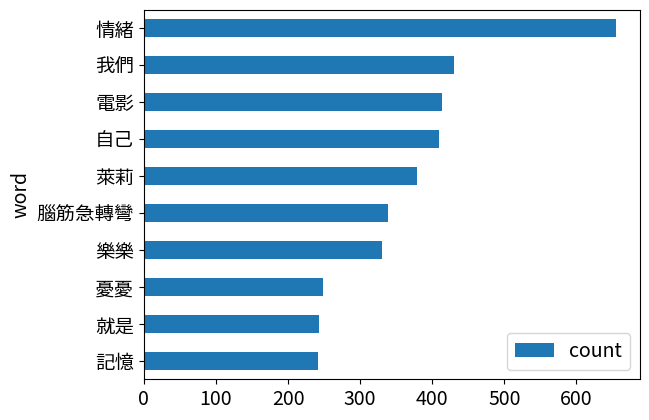

In [ ]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

### 2.5 繪製文字雲

In [ ]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

print(dict(list(freq_dict.items())[:10]))

{'情緒': 655, '我們': 430, '電影': 414, '自己': 410, '萊莉': 379, '腦筋急轉彎': 338, '樂樂': 330, '憂憂': 248, '就是': 243, '記憶': 241}


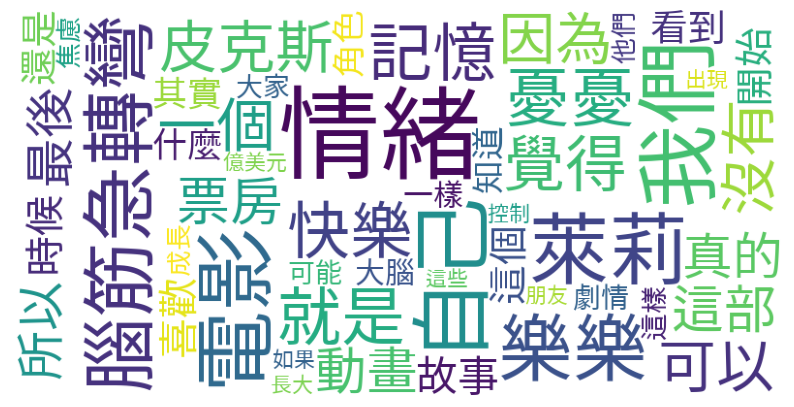

In [ ]:
# 繪製文字雲
from wordcloud import WordCloud
FontPath = 'TaipeiSansTCBeta-Regular.ttf' # 設定字型

wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('drive/MyDrive/dict/stop_words.txt', 'r', encoding='utf-8').readlines()]

#移除dataframe中的停用字
noStop_df = word_df[~word_df['word'].isin(stopwords)]

noStop_df.head(10)

title        date  \
1  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
1  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   

                                                link  \
1  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
1  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   

                                             content  word  
1  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    之前  
1  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    腦筋  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    喜歡  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    夢境  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   製片廠  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    橋段  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...  Bing  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...  Bong  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    樂樂  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    憂憂

<ipython-input-91-4a75f80ce117>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


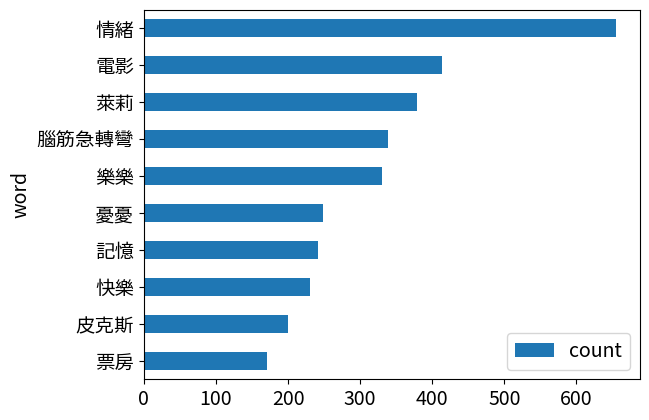

In [ ]:
#再次繪製長條圖
freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_nostop.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

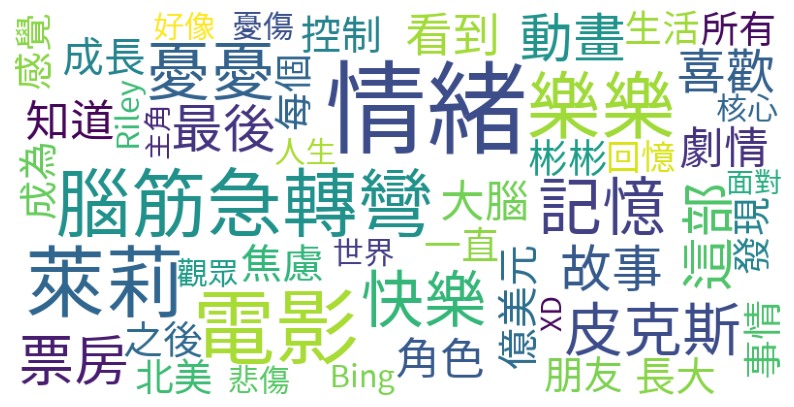

In [ ]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 再次繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

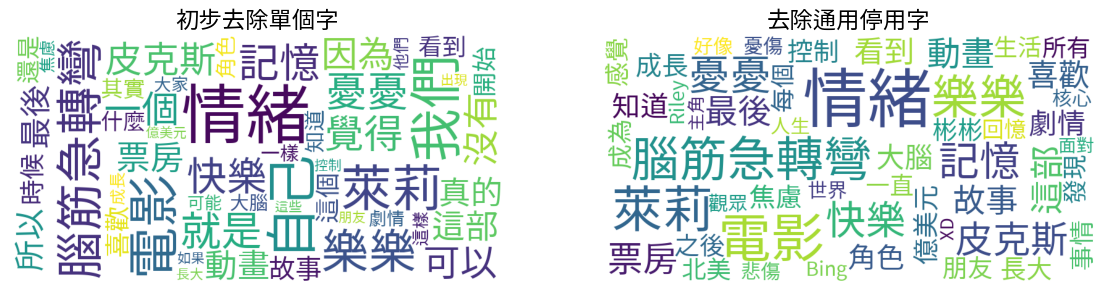

In [ ]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("初步去除單個字")

plt.subplot(1,2,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除通用停用字")

plt.show()

In [ ]:
# 參數形式手動加入停用字
stopwords_manual = ["好像", "之後", "每個", "感覺", "事情", "看到", "世界", "發現", "成為", "知道", "這部", "看完", "一直", "故事", "表現", "觀眾", "完全", "無法", "需要", "出現", "XD"]
stopwords.extend(stopwords_manual)

noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2.head(10)

title        date  \
1  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
1  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   

                                                link  \
1  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
1  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   

                                             content  word  
1  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    之前  
1  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    腦筋  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    喜歡  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    夢境  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   製片廠  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    橋段  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...  Bing  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...  Bong  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    樂樂  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...    憂憂

<ipython-input-95-ad300228c97c>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()


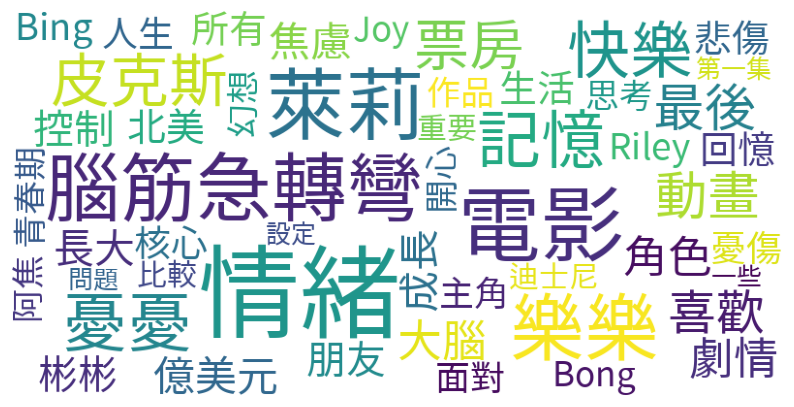

In [ ]:
# 計算詞頻
freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()

# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict_nostop_2 = freq_df_nostop_2.set_index('word').to_dict()
freq_dict_nostop_2 = freq_dict_nostop_2['count']

# 第三次繪製文字雲
wordcloud_nostop_2 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop_2.generate_from_frequencies(freq_dict_nostop_2)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.show()

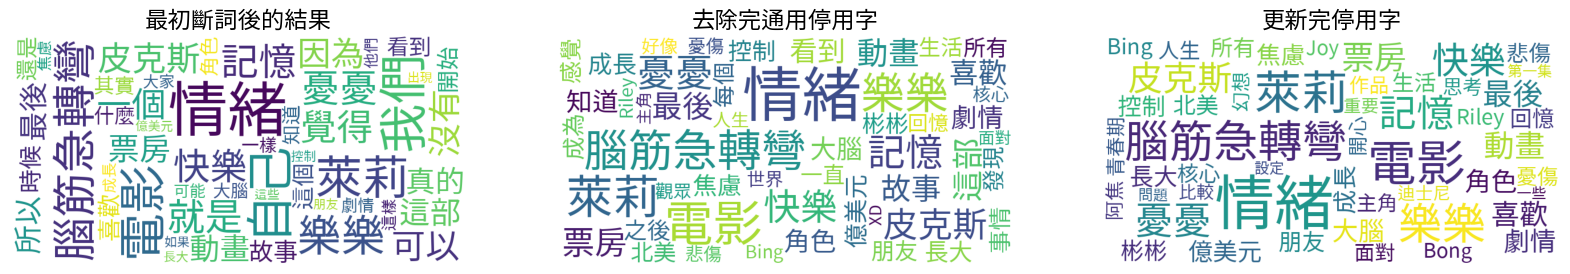

In [ ]:
plt.figure(figsize = (20,14))

plt.subplot(1,3,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("最初斷詞後的結果")

plt.subplot(1,3,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除完通用停用字")

plt.subplot(1,3,3)
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.title("更新完停用字")

plt.show()

可以看到一些無意義的字詞被去除了

## 3.情緒分析一

### 3.1 lexicon-base 情緒分析
- 進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併。

In [ ]:
# 讀取情緒字典
liwc_dict = pd.read_csv("drive/MyDrive/dict//LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

In [ ]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

In [ ]:
#將情緒字典與斷詞結果進行合併
ptt_liwc_df = pd.merge(noStop_df_2[["title", "date", "link", "content", "word"]], liwc_dict, how="left")
ptt_liwc_df

title        date  \
0      [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
1      [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2      [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3      [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
4      [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
...                         ...         ...   
41697        [好雷]《腦筋急轉彎》成人卡通新高峰  2015-08-13   
41698        [好雷]《腦筋急轉彎》成人卡通新高峰  2015-08-13   
41699        [好雷]《腦筋急轉彎》成人卡通新高峰  2015-08-13   
41700        [好雷]《腦筋急轉彎》成人卡通新高峰  2015-08-13   
41701        [好雷]《腦筋急轉彎》成人卡通新高峰  2015-08-13   

                                                    link  \
0      https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
1      https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2      https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3      https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
4      https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
...                                                  ...   
41697  https://www.ptt.cc/bbs/movie/M.1439445246.A.99...   
41698  https://www.ptt.cc/bbs/movie/M.1439445246.A.99...   
41699  https://www.ptt.cc/bbs/movie/M.1439445246.A.99...   
41700  https://www.ptt.cc/bbs/movie/M.1439445246.A.99...   
41701  https://www.ptt.cc/bbs/movie/M.1439445246.A.99...   

                                                 content word sentiments  
0      https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   之前        NaN  
1      https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   腦筋        NaN  
2      https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   喜歡     affect  
3      https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   喜歡   positive  
4      https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   夢境        NaN  
...                                                  ...  ...        ...  
41697  完整原文連結\nhttp://jiyulin.pixnet.net/blog/post/43...  皮克斯        NaN  
41698  完整原文連結\nhttp://jiyulin.pixnet.net/blog/post/43...   努力        NaN  
41699  完整原文連結\nhttp://jiyulin.pixnet.net/blog/post/43...   尋找        NaN  
41700  完整原文連結\nhttp://jiyulin.pixnet.net/blog/post/43...   更多        NaN  
41701  完整原文連結\nhttp://jiyulin.pixnet.net/blog/post/43...  可能性        NaN  

[41702 rows x 6 columns]

In [ ]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["date", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative")
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["date"])
sentiment_count

date sentiments  size
3    2015-08-13   negative    42
4    2015-08-13   positive    43
9    2015-08-14   negative   128
10   2015-08-14   positive   154
15   2015-08-15   negative    52
..          ...        ...   ...
514  2024-11-06   positive     2
519  2024-11-12   negative     3
520  2024-11-12   positive     4
523  2024-12-06   negative     1
524  2024-12-06   positive     3

[199 rows x 3 columns]

### 3.2 觀察發文頻率

透過觀察發文頻率以找出引起最多討論的時期。

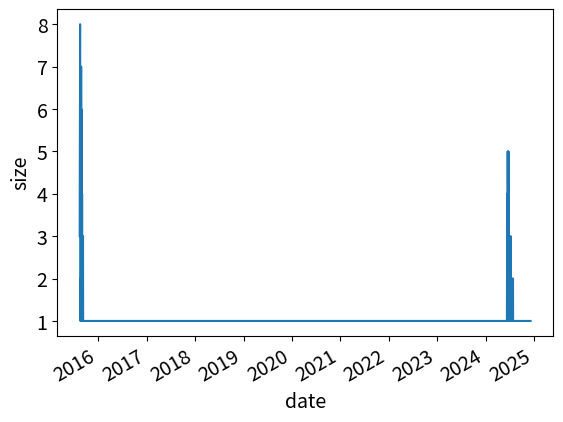

In [ ]:
ptt_df = df.copy()
#只看日期，不抓時間

ptt_df["date"] = pd.to_datetime(ptt_df["date"])
ptt_df["date"] = ptt_df["date"].dt.date


#畫圖
ptt_line_plot = ptt_df.groupby(["date"], as_index=False).size()
fig, ax = plt.subplots()

ax.plot(ptt_line_plot["date"], ptt_line_plot["size"])
ax.set_xlabel("date")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()

腦筋急轉彎第一集於2015年上映，續集於2024年上映，可見討論度在上映期間最為熱烈

### 3.3 正負向情緒詞彙頻率折線圖

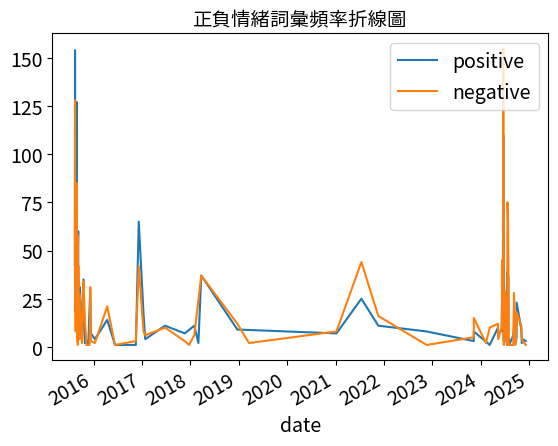

In [ ]:
colors = ["tab:blue", "tab:orange"]
# 轉換 date 格式為 YYYY-MM
sentiment_count["date"] = pd.to_datetime(sentiment_count["date"])
sentiment_count["year_month"] = sentiment_count["date"].dt.to_period("M")
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["date"], pos["size"], color=colors[0])
ax.plot(neg["date"], neg["size"], color=colors[1])

plt.xlabel("date")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

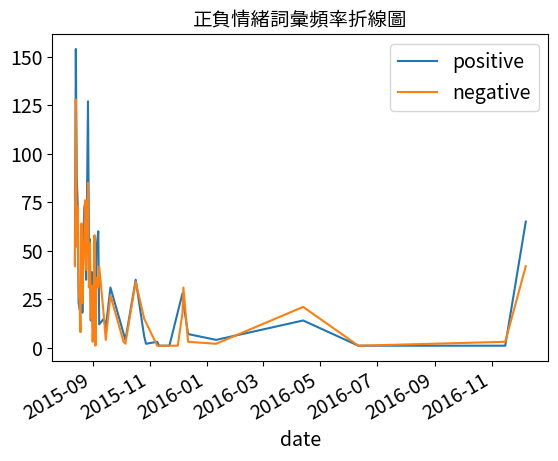

In [ ]:
colors = ["tab:blue", "tab:orange"]
# 轉換 date 格式為 YYYY-MM
sentiment_count["date"] = pd.to_datetime(sentiment_count["date"])
sentiment_count["year_month"] = sentiment_count["date"].dt.to_period("M")
#2015-2016年
pos = sentiment_count[(sentiment_count["sentiments"] == "positive") &
                      (sentiment_count["date"] >= "2015-01-01") &
                      (sentiment_count["date"] <= "2016-12-31")]

neg = sentiment_count[(sentiment_count["sentiments"] == "negative") &
                      (sentiment_count["date"] >= "2015-01-01") &
                      (sentiment_count["date"] <= "2016-12-31")]

# fig, ax = plt.subplots(figsize = (10,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["date"], pos["size"], color=colors[0])
ax.plot(neg["date"], neg["size"], color=colors[1])

plt.xlabel("date")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

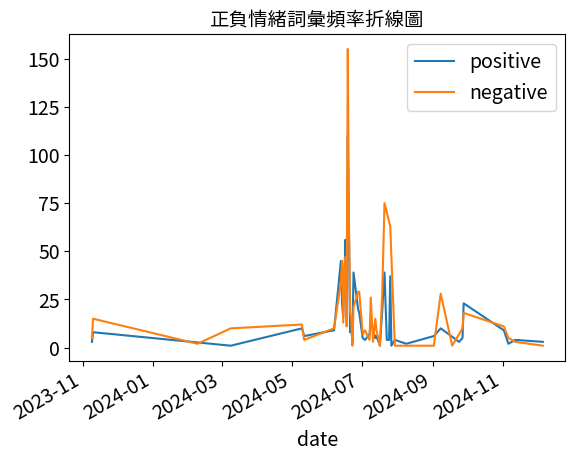

In [ ]:
colors = ["tab:blue", "tab:orange"]
# 轉換 date 格式為 YYYY-MM
sentiment_count["date"] = pd.to_datetime(sentiment_count["date"])
sentiment_count["year_month"] = sentiment_count["date"].dt.to_period("M")
#2023-2024年
pos = sentiment_count[(sentiment_count["sentiments"] == "positive") &
                      (sentiment_count["date"] >= "2023-01-01") &
                      (sentiment_count["date"] <= "2024-12-31")]

neg = sentiment_count[(sentiment_count["sentiments"] == "negative") &
                      (sentiment_count["date"] >= "2023-01-01") &
                      (sentiment_count["date"] <= "2024-12-31")]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["date"], pos["size"], color=colors[0])
ax.plot(neg["date"], neg["size"], color=colors[1])

plt.xlabel("date")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

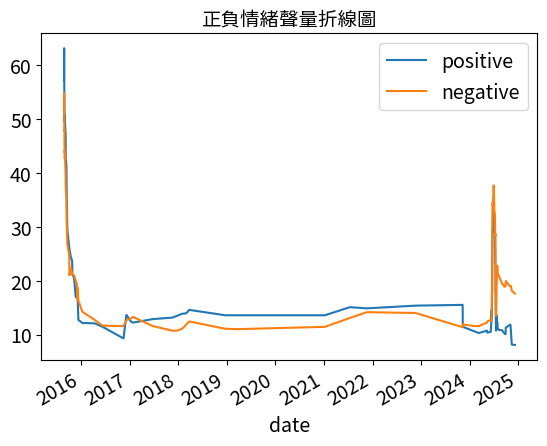

In [ ]:
# moving average

colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[(sentiment_count["sentiments"] == "positive")]

neg = sentiment_count[(sentiment_count["sentiments"] == "negative")]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["date"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["date"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("date")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

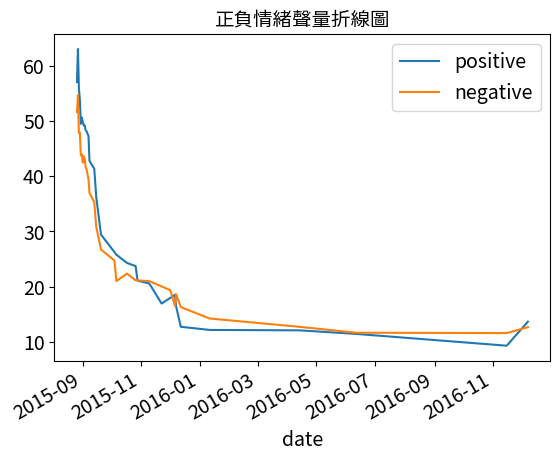

In [ ]:
# moving average

colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[(sentiment_count["sentiments"] == "positive") &
                      (sentiment_count["date"] >= "2015-01-01") &
                      (sentiment_count["date"] <= "2016-12-31")]

neg = sentiment_count[(sentiment_count["sentiments"] == "negative") &
                      (sentiment_count["date"] >= "2015-01-01") &
                      (sentiment_count["date"] <= "2016-12-31")]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["date"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["date"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("date")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

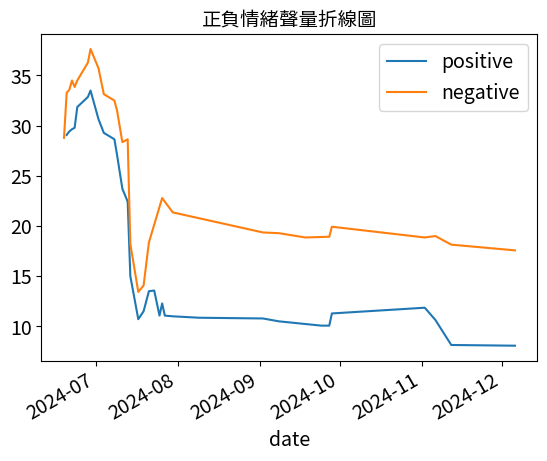

In [ ]:
# moving average

colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[(sentiment_count["sentiments"] == "positive") &
                      (sentiment_count["date"] >= "2023-01-01") &
                      (sentiment_count["date"] <= "2024-12-31")]

neg = sentiment_count[(sentiment_count["sentiments"] == "negative") &
                      (sentiment_count["date"] >= "2023-01-01") &
                      (sentiment_count["date"] <= "2024-12-31")]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["date"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["date"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("date")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

經折線圖大略可見:
- 在腦筋急轉彎第一集，正面情緒略高於負面情緒
- 在腦筋急轉彎第二集，負面情緒高於正面情緒


### 3.4 正負向情緒詞彙比例折線圖

In [ ]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("date")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

date sentiments  size year_month     ratio
3   2015-08-13   negative    42    2015-08  0.494118
4   2015-08-13   positive    43    2015-08  0.505882
9   2015-08-14   negative   128    2015-08  0.453901
10  2015-08-14   positive   154    2015-08  0.546099
15  2015-08-15   negative    52    2015-08  0.374101
..         ...        ...   ...        ...       ...
514 2024-11-06   positive     2    2024-11  0.285714
519 2024-11-12   negative     3    2024-11  0.428571
520 2024-11-12   positive     4    2024-11  0.571429
523 2024-12-06   negative     1    2024-12  0.250000
524 2024-12-06   positive     3    2024-12  0.750000

[199 rows x 5 columns]

In [ ]:
pos = sentiment_count[(sentiment_count["sentiments"] == "positive")]

neg = sentiment_count[(sentiment_count["sentiments"] == "negative")]

Text(0.5, 1.0, '正負情緒比例折線圖')

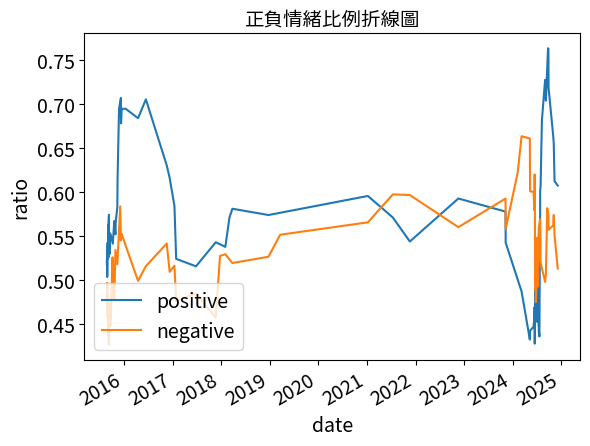

In [ ]:
fig, ax = plt.subplots()

rolling_days = 10
ax.plot(pos["date"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["date"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("date")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

In [ ]:
pos = sentiment_count[(sentiment_count["sentiments"] == "positive") &
                      (sentiment_count["date"] >= "2015-01-01") &
                      (sentiment_count["date"] <= "2016-12-31")]

neg = sentiment_count[(sentiment_count["sentiments"] == "negative") &
                      (sentiment_count["date"] >= "2015-01-01") &
                      (sentiment_count["date"] <= "2016-12-31")]

Text(0.5, 1.0, '正負情緒比例折線圖')

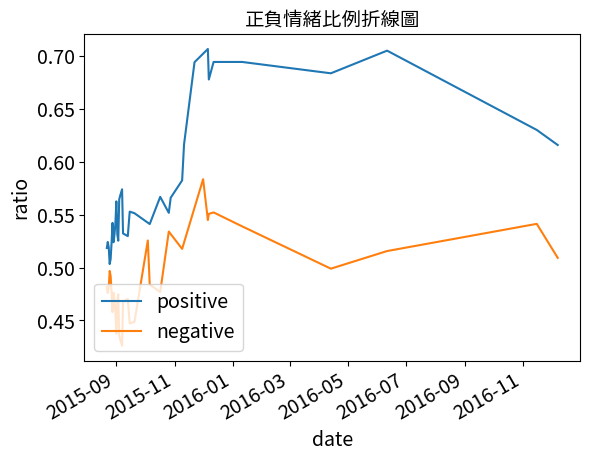

In [ ]:
fig, ax = plt.subplots()

rolling_days = 10
ax.plot(pos["date"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["date"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("date")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

腦筋急轉彎第一集，正面情緒高於負面情緒

In [ ]:
pos = sentiment_count[(sentiment_count["sentiments"] == "positive") &
                      (sentiment_count["date"] >= "2023-01-01") &
                      (sentiment_count["date"] <= "2024-12-31")]

neg = sentiment_count[(sentiment_count["sentiments"] == "negative") &
                      (sentiment_count["date"] >= "2023-01-01") &
                      (sentiment_count["date"] <= "2024-12-31")]

Text(0.5, 1.0, '正負情緒比例折線圖')

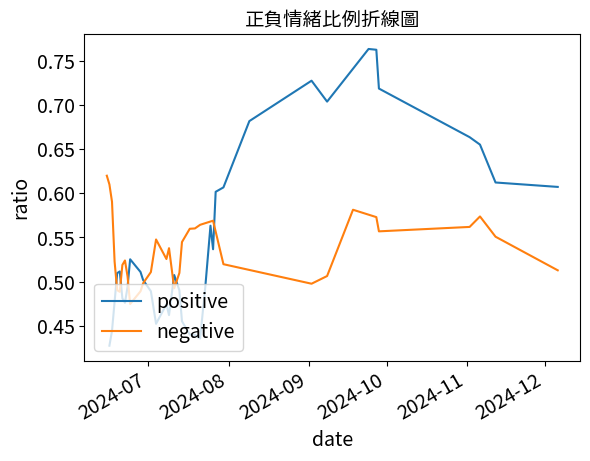

In [ ]:
fig, ax = plt.subplots()

rolling_days = 10
ax.plot(pos["date"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["date"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("date")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

腦筋急轉彎第二集，起先負面情緒略高於正面情緒，後期正面情緒高於負面情緒

In [ ]:
sentiment_count

date sentiments  size year_month     ratio
3   2015-08-13   negative    42    2015-08  0.494118
4   2015-08-13   positive    43    2015-08  0.505882
9   2015-08-14   negative   128    2015-08  0.453901
10  2015-08-14   positive   154    2015-08  0.546099
15  2015-08-15   negative    52    2015-08  0.374101
..         ...        ...   ...        ...       ...
514 2024-11-06   positive     2    2024-11  0.285714
519 2024-11-12   negative     3    2024-11  0.428571
520 2024-11-12   positive     4    2024-11  0.571429
523 2024-12-06   negative     1    2024-12  0.250000
524 2024-12-06   positive     3    2024-12  0.750000

[199 rows x 5 columns]

### 3.5 正負面情緒分數折線圖
透過正負面情緒分數來了解發文者對腦筋急轉彎相關議題的情緒。

In [ ]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="date", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

date  negative  positive
0 2015-08-13      42.0      43.0
1 2015-08-14     128.0     154.0
2 2015-08-15      52.0      87.0
3 2015-08-16      73.0      74.0
4 2015-08-17      29.0      23.0

In [ ]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    -ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

date  negative  positive  sentiment_value
0 2015-08-13      42.0      43.0              1.0
1 2015-08-14     128.0     154.0             26.0
2 2015-08-15      52.0      87.0             35.0
3 2015-08-16      73.0      74.0              1.0
4 2015-08-17      29.0      23.0             -6.0

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

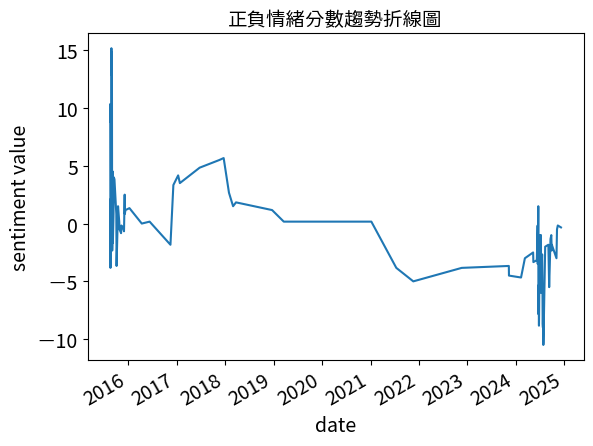

In [ ]:
fig, ax = plt.subplots()

rolling_days = 6
ax.plot(ptt_sentiment_value["date"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("date")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

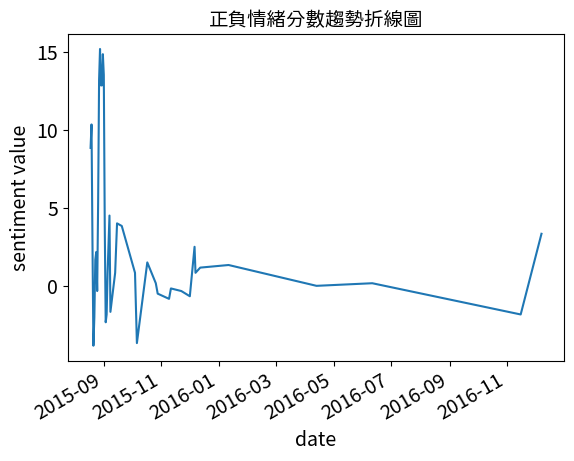

In [ ]:
#2015-2016
filtered_data = ptt_sentiment_value[
    (ptt_sentiment_value["date"] >= "2015-01-01") &
    (ptt_sentiment_value["date"] <= "2016-12-31")
]

fig, ax = plt.subplots()
rolling_days = 6

ax.plot(filtered_data["date"],
        filtered_data["sentiment_value"].rolling(rolling_days).mean())

ax.set_xlabel("date")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)
plt.show()

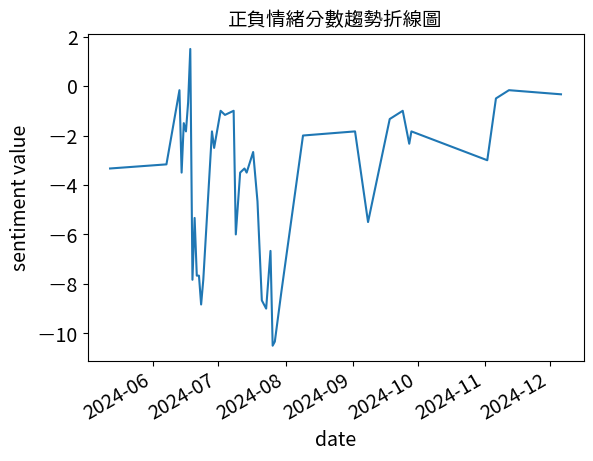

In [ ]:
#2023-2024
filtered_data = ptt_sentiment_value[
    (ptt_sentiment_value["date"] >= "2023-01-01") &
    (ptt_sentiment_value["date"] <= "2024-12-31")
]

fig, ax = plt.subplots()
rolling_days = 6

ax.plot(filtered_data["date"],
        filtered_data["sentiment_value"].rolling(rolling_days).mean())

ax.set_xlabel("date")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)
plt.show()

可以看出:
- 第一集正向情緒明顯高於第二集
- 第一集後期分數趨勢線下降，應該是因為討論度下降的關係
- 第二集後期分數趨勢線上升

### 3.6 文章為單位的情緒分析

In [ ]:
sentiment_count_by_article = pd.DataFrame(
   ptt_liwc_df.groupby(["link", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

link sentiments  size
0    https://www.ptt.cc/bbs/movie/M.1439445246.A.99...     affect    54
1    https://www.ptt.cc/bbs/movie/M.1439445246.A.99...      anger     4
2    https://www.ptt.cc/bbs/movie/M.1439445246.A.99...        anx     7
3    https://www.ptt.cc/bbs/movie/M.1439445246.A.99...   negative    28
4    https://www.ptt.cc/bbs/movie/M.1439445246.A.99...   positive    25
..                                                 ...        ...   ...
850  https://www.ptt.cc/bbs/movie/M.1731402388.A.8D...   positive     4
851  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...     affect     4
852  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...        anx     1
853  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   negative     1
854  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   positive     3

[855 rows x 3 columns]

In [ ]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="link", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

link  affect  anger  anx  \
0  https://www.ptt.cc/bbs/movie/M.1439445246.A.99...    54.0    4.0  7.0   
1  https://www.ptt.cc/bbs/movie/M.1439459981.A.AA...     2.0    0.0  0.0   
2  https://www.ptt.cc/bbs/movie/M.1439478067.A.CB...    33.0    1.0  4.0   
3  https://www.ptt.cc/bbs/movie/M.1439484378.A.79...    15.0    0.0  1.0   
4  https://www.ptt.cc/bbs/movie/M.1439502380.A.FD...   103.0   11.0  5.0   

   negative  positive   sad  
0      28.0      25.0   6.0  
1       1.0       1.0   0.0  
2      13.0      17.0   3.0  
3       7.0       7.0   4.0  
4      55.0      42.0  15.0

In [ ]:
#  sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
   ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

link  affect  anger  anx  \
0  https://www.ptt.cc/bbs/movie/M.1439445246.A.99...    54.0    4.0  7.0   
1  https://www.ptt.cc/bbs/movie/M.1439459981.A.AA...     2.0    0.0  0.0   
2  https://www.ptt.cc/bbs/movie/M.1439478067.A.CB...    33.0    1.0  4.0   
3  https://www.ptt.cc/bbs/movie/M.1439484378.A.79...    15.0    0.0  1.0   
4  https://www.ptt.cc/bbs/movie/M.1439502380.A.FD...   103.0   11.0  5.0   

   negative  positive   sad  sentiment_value  
0      28.0      25.0   6.0             -3.0  
1       1.0       1.0   0.0              0.0  
2      13.0      17.0   3.0              4.0  
3       7.0       7.0   4.0              0.0  
4      55.0      42.0  15.0            -13.0

In [ ]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

link  affect  anger  anx  \
0    https://www.ptt.cc/bbs/movie/M.1439445246.A.99...    54.0    4.0  7.0   
1    https://www.ptt.cc/bbs/movie/M.1439459981.A.AA...     2.0    0.0  0.0   
2    https://www.ptt.cc/bbs/movie/M.1439478067.A.CB...    33.0    1.0  4.0   
3    https://www.ptt.cc/bbs/movie/M.1439484378.A.79...    15.0    0.0  1.0   
4    https://www.ptt.cc/bbs/movie/M.1439502380.A.FD...   103.0   11.0  5.0   
..                                                 ...     ...    ...  ...   
183  https://www.ptt.cc/bbs/movie/M.1727531647.A.21...    47.0    1.0  6.0   
184  https://www.ptt.cc/bbs/movie/M.1730512420.A.83...    20.0    2.0  0.0   
185  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...     9.0    1.0  3.0   
186  https://www.ptt.cc/bbs/movie/M.1731402388.A.8D...     7.0    1.0  1.0   
187  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...     4.0    0.0  1.0   

     negative  positive   sad  sentiment_value sentiment_class  
0        28.0      25.0   6.0             -3.0              負向  
1         1.0       1.0   0.0              0.0              負向  
2        13.0      17.0   3.0              4.0              正向  
3         7.0       7.0   4.0              0.0              負向  
4        55.0      42.0  15.0            -13.0              負向  
..        ...       ...   ...              ...             ...  
183      18.0      23.0   3.0              5.0              正向  
184      11.0       9.0   1.0             -2.0              負向  
185       5.0       2.0   2.0             -3.0              負向  
186       3.0       4.0   0.0              1.0              正向  
187       1.0       3.0   0.0              2.0              正向  

[188 rows x 9 columns]

In [ ]:
ptt_sentiment_value_by_article['sentiment_class'].value_counts()

sentiment_class
負向    95
正向    93
Name: count, dtype: int64

In [ ]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['link', 'sentiment_class']], how="left")
clear_df_sentiment["date"] = pd.to_datetime(clear_df_sentiment["date"])
clear_df_sentiment['date'] = clear_df_sentiment['date'].dt.date
clear_df_sentiment

title  \
0    [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   
1                 [普雷] 腦筋急轉彎2   
2           [普雷] 腦筋急轉彎2 想再次二刷   
3    [普雷] 腦筋急轉彎2 Inside Out 2   
4       Re: [討論] 覺得腦筋急轉彎好看的原因   
..                        ...   
195                [好雷] 腦筋急轉彎   
196               [好雷] 腦筋急轉彎    
197   [好雷] 腦筋急轉彎～內心有個小宇宙，爆淚阿~   
198      [請益] 今天要去二刷超好看的腦筋急轉彎   
199        [好雷]《腦筋急轉彎》成人卡通新高峰   

                                                  link        date  \
0    https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   
1    https://www.ptt.cc/bbs/movie/M.1731402388.A.8D...  2024-11-12   
2    https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...  2024-11-06   
3    https://www.ptt.cc/bbs/movie/M.1730512420.A.83...  2024-11-02   
4    https://www.ptt.cc/bbs/movie/M.1727531647.A.21...  2024-09-28   
..                                                 ...         ...   
195  https://www.ptt.cc/bbs/movie/M.1439502380.A.FD...  2015-08-14   
196  https://www.ptt.cc/bbs/movie/M.1439484378.A.79...  2015-08-14   
197  https://www.ptt.cc/bbs/movie/M.1439478067.A.CB...  2015-08-13   
198  https://www.ptt.cc/bbs/movie/M.1439459981.A.AA...  2015-08-13   
199  https://www.ptt.cc/bbs/movie/M.1439445246.A.99...  2015-08-13   

                                               content sentiment_class  
0    https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...              正向  
1    雷文防雷資訊頁\n\n\n\n\n\n\n\n~~~~~~~~~~~~~~~~~~~ 雷文 ...              正向  
2    雷文防雷資訊頁\n\n\n\n\n\n\n\n~*-*~*-*~*-*~*-*~*-*~*-...              負向  
3    ~~~~~~~~~~~~~~~~~~~ 雷文 主文分隔線 ~~~~~~~~~~~~~~~~~...              負向  
4    原PO你好，你在文章裡用的舉例跟形容讓我很有想法，\n這邊針對一些段落回覆跟討論。\n\n\...              正向  
..                                                 ...             ...  
195  小時候哭著哭著就笑了，長大後卻笑著笑著就哭了\n\n失控的正向思考，總是不經意的襲擊與主宰著...              負向  
196  適合小朋友、大朋友看的好片\n\n將腦中的情緒具體化為實體人物\n\n有看到很想巴下去的憂鬱...              負向  
197  豐富圖文版:http://paulyear.pixnet.net/blog/post/614...              正向  
198  今天想看看中配\n但以前迪士尼的中配經驗都不好...\n找了網路也沒有中配預告片\n請問有人...              負向  
199  完整原文連結\nhttp://jiyulin.pixnet.net/blog/post/43...              負向  

[200 rows x 5 columns]

In [ ]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["date", "sentiment_class"]).size()
).reset_index()

#統計每種情感分類在每個日期下的文章數量
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["date"])
sentiment_art_count

date sentiment_class  size
0    2015-08-13              正向     1
1    2015-08-13              負向     2
2    2015-08-14              正向     3
3    2015-08-14              負向     2
4    2015-08-15              正向     5
..          ...             ...   ...
127  2024-09-28              正向     1
128  2024-11-02              負向     1
129  2024-11-06              負向     1
130  2024-11-12              正向     1
131  2024-12-06              正向     1

[132 rows x 3 columns]

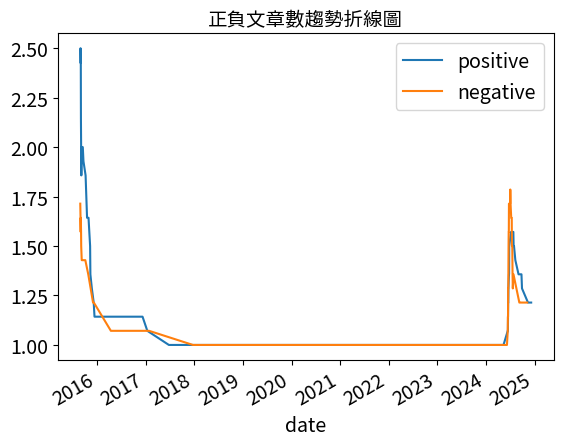

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["date"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["date"], neg["size"].rolling(rolling_days).mean(), color=colors[1])


plt.xlabel("date")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

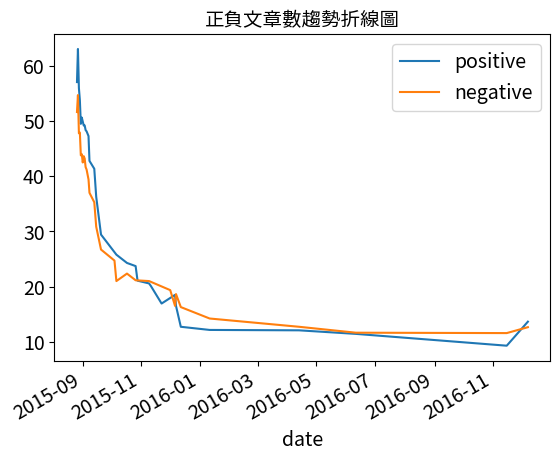

In [ ]:
pos = sentiment_count[(sentiment_count["sentiments"] == "positive") &
                      (sentiment_count["date"] >= "2015-01-01") &
                      (sentiment_count["date"] <= "2016-12-31")]

neg = sentiment_count[(sentiment_count["sentiments"] == "negative") &
                      (sentiment_count["date"] >= "2015-01-01") &
                      (sentiment_count["date"] <= "2016-12-31")]

fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["date"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["date"], neg["size"].rolling(rolling_days).mean(), color=colors[1])


plt.xlabel("date")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

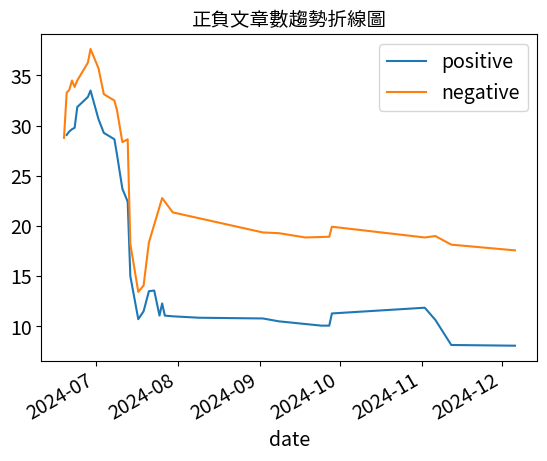

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[(sentiment_count["sentiments"] == "positive") &
                      (sentiment_count["date"] >= "2023-01-01") &
                      (sentiment_count["date"] <= "2024-12-31")]

neg = sentiment_count[(sentiment_count["sentiments"] == "negative") &
                      (sentiment_count["date"] >= "2023-01-01") &
                      (sentiment_count["date"] <= "2024-12-31")]

fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["date"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["date"], neg["size"].rolling(rolling_days).mean(), color=colors[1])


plt.xlabel("date")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

同樣是第一集正面情緒高於負面情緒，第二集負面情緒高於正面情緒

### 3.7 情緒代表字

In [ ]:
word_count =ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

word sentiments  size
635   情緒     affect   655
636   情緒   negative   655
595   快樂     affect   231
596   快樂   positive   231
328   喜歡     affect   134
..   ...        ...   ...
21    不幸        sad     1
20    不幸   negative     1
19    不幸     affect     1
490   寬容   positive     1
489   寬容     affect     1

[1562 rows x 3 columns]

In [ ]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

word sentiments  size
596    快樂   positive   231
329    喜歡   positive   134
876    朋友   positive    84
78     作品   positive    65
535    幻想   positive    63
1467   開心   positive    62
1456   重要   positive    59
874    有趣   positive    48
511    希望   positive    41
891    樂觀   positive    36
651    想像   positive    36
93     值得   positive    35
1203   簡單   positive    35
1367   謝謝   positive    34
920    正面   positive    34

In [ ]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

word sentiments  size
636    情緒   negative   655
1052   焦慮   negative    94
791    控制   negative    87
619    悲傷   negative    74
686    憂傷   negative    70
311    問題   negative    57
1286   自我   negative    52
1496   難過   negative    42
701    憤怒   negative    40
1166   眼淚   negative    32
481    害怕   negative    30
696    憂鬱   negative    29
1086   犧牲   negative    28
1343   討厭   negative    27
808    擔心   negative    27

<ipython-input-314-91034b930d2b>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
<ipython-input-314-91034b930d2b>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

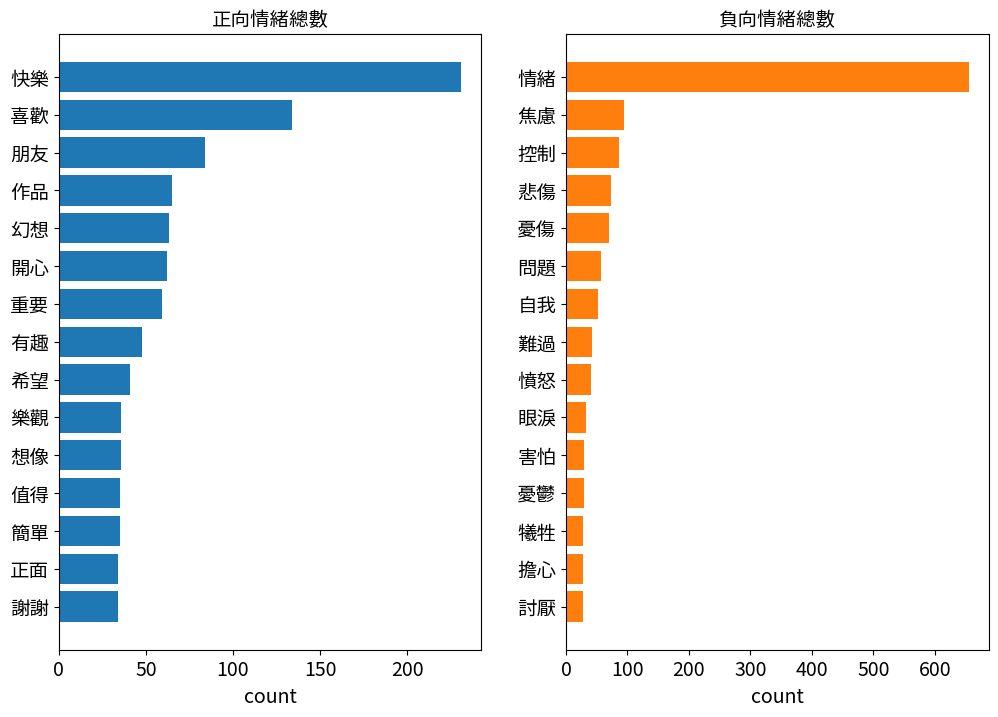

In [ ]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2,figsize=(12, 8))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

In [ ]:
filtered_df = sent_df[sent_df['sentence'].str.contains('希望', na=False)]
filtered_df.head()

title       date  \
1381  [微微好雷] 腦筋急轉彎1-比第二部好看0.03吧笑死 2024-06-29   
2746        [普好微雷] 腦筋急轉彎2：成長了 但不多 2024-06-18   
3001     [新聞] 皮克斯再刷新一堆票房紀錄！腦筋急轉彎2 2024-06-17   
3229                  [好雷] 腦筋急轉彎2 2024-06-16   
3342       [好雷] 腦筋急轉彎2 青春期的焦慮與不安  2024-06-14   

                                                   link  \
1381  https://www.ptt.cc/bbs/movie/M.1719666908.A.8B...   
2746  https://www.ptt.cc/bbs/movie/M.1718683253.A.F6...   
3001  https://www.ptt.cc/bbs/movie/M.1718613726.A.53...   
3229  https://www.ptt.cc/bbs/movie/M.1718538306.A.6C...   
3342  https://www.ptt.cc/bbs/movie/M.1718372568.A.89...   

                                                content  \
1381  首先  這部有雷1跟2  劇透注意  沒看過2怕劇透也請先離開\n\n\n警告區  警告區 ...   
2746  雷文防雷資訊頁\n\n先說結論\n個人認為值得一看\n但不能抱著會收穫許多感動的期待\n這部...   
3001  新聞網址：\n\nhttps://reurl.cc/r9Vg11\n\n新聞來源：\n\n關...   
3229  先說結論，身為皮克斯的忠實老粉，我非常喜歡這次的《腦２》。\n\n提供一下近五年皮克斯作品的...   
3342  怕有雷先防雷\n\n.\n\n..\n\n…\n\n…\n\n……\n\n…\n\n…\n\...   

                   sentence sentiment_class  
1381      希望別再出第三集了  只會越來越爛              負向  
2746  滿希望看到每個新角色都有屬於自己的記憶時刻              正向  
3001        並希望觀眾對於旗下動畫片的熱愛              正向  
3229         但還是希望能看到更多的阿慕啊              負向  
3342  更希望可以成為曲棍球校隊一員等眾多因素交織              負向

檢查情緒詞

In [ ]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

希望別再出第三集了  只會越來越爛
滿希望看到每個新角色都有屬於自己的記憶時刻
並希望觀眾對於旗下動畫片的熱愛
但還是希望能看到更多的阿慕啊
更希望可以成為曲棍球校隊一員等眾多因素交織
希望他們別再迷失自己
觀眾長大當然希望能夠口味重一點
希望不要砸了第一集神作的招牌啊
總希望無時無刻都能抱有美好的歡笑與記憶
希望大家看片愉快
希望能有喜歡這部電影的朋友 分享一下個人心得 或一些相關經驗
並希望皮克斯能給她應得的補償
希望大家都能回憶起小時候曾出現的那位Bing Bong
希望 Riley 可以過得更好
希望之
還說希望有天能跟大象記憶一樣好
希望下一部能讓我看到的不是討好廣大客群的片
所以一開始就希望能用無窮盡的正面能量去改變她影
不難看出他們的確是希望能
樂樂是希望追逐自身的快樂而行
希望這多少能彌補我們犧牲夢想的眼淚
希望這部優質動畫能分享給更多人
希望皮克斯還是可以突破自已
只希望她開心起來
甘願化為虛無也希望小女孩Riley快樂
但卻保留著微小而強壯的希望
總是希望身邊所有人開心
不希望記憶被
希望能有更多人看到
樂樂希望所有的核心記憶都是快樂的
希望看完三人都可以是開心感動的
一方面希望票房可以開紅盤
希望有第二集可以多出現別人控制台的畫面
但希望迪士尼與導演的思考能夠更加謹慎
希望你們永遠都不要長大
希望很長的心得不會讓大家覺得廢話很多
以上的發文問的問題只是希望他不要勉強自己看
沒有人希望是憂傷
無非是希望重新回過頭檢討那個被我們斬斷的情感連結
希望能有續集再哭一次
希望有續集


In [ ]:
# 設定要移除的字詞列表
words_to_remove = ['問題','自我','控制','希望']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["link", "date", "title", "content","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

link        date  \
0  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   
1  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   
4  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   

                      title  \
0  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   
1  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   
4  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   

                                             content word sentiments  
0  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   之前        NaN  
1  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   腦筋        NaN  
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   喜歡     affect  
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   喜歡   positive  
4  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   夢境        NaN

重新計算情緒

<ipython-input-317-aa241a889493>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
<ipython-input-317-aa241a889493>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

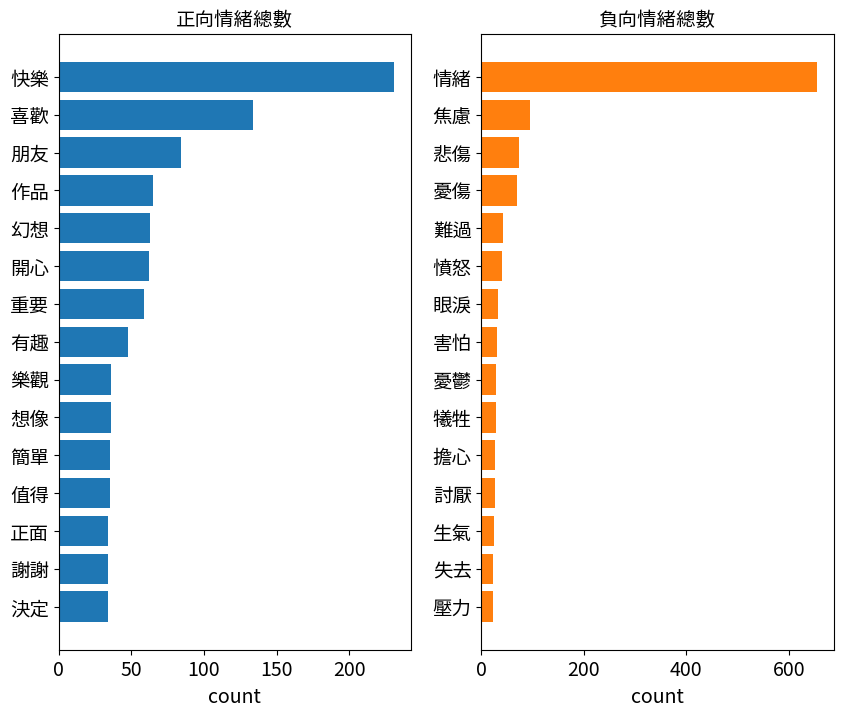

In [ ]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2,figsize=(10, 8))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

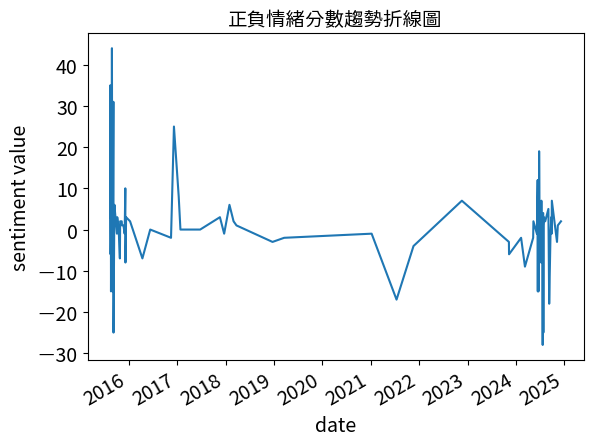

In [ ]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["date", "sentiments"]).size()
).reset_index()

# 轉換 date 格式為 YYYY-MM
sentiment_count_revise["date"] = pd.to_datetime(sentiment_count_revise["date"])
sentiment_count_revise["year_month"] = sentiment_count_revise["date"].dt.to_period("M")

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative")
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["date"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="date", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 1
ax.plot(ptt_sentiment_value_revise["date"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("date")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

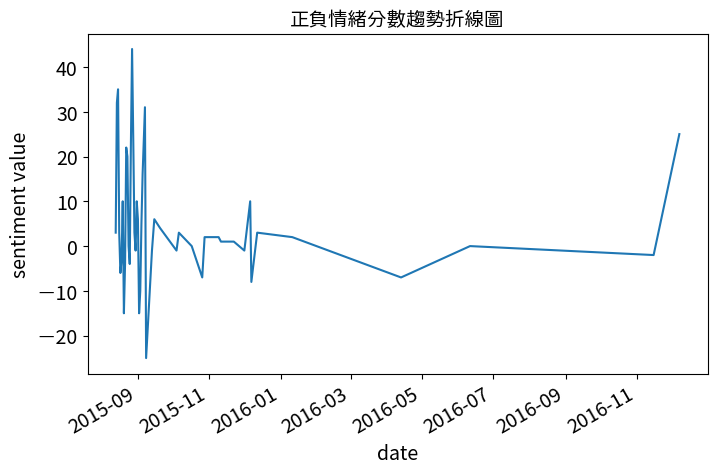

In [ ]:
#sentiment_count_revise["date"] = pd.to_datetime(sentiment_count_revise["date"])
# 轉換 date 格式為 YYYY-MM
#sentiment_count["date"] = pd.to_datetime(sentiment_count["date"])
#sentiment_count["year_month"] = sentiment_count["date"].dt.to_period("M")

#2015-2016
sentiment_count_revise = sentiment_count_revise[
    (sentiment_count_revise["date"] >= "2015-01-01") &
    (sentiment_count_revise["date"] <= "2016-12-31")
]

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="date", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots(figsize=(8, 5))

rolling_days = 1
ax.plot(ptt_sentiment_value_revise["date"],
        ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())

ax.set_xlabel("date")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)
plt.show()

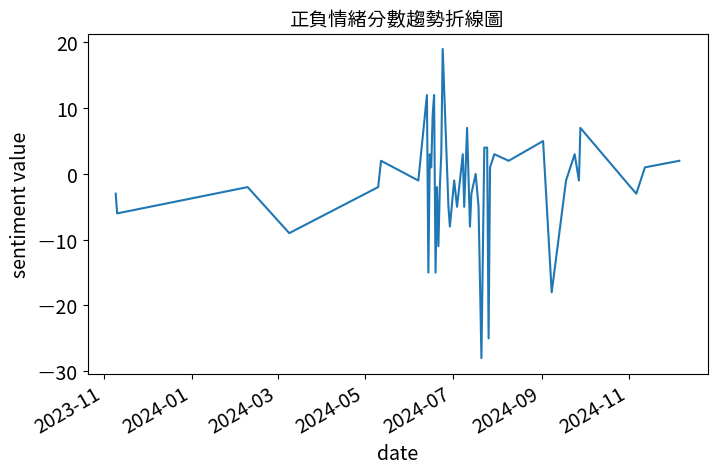

In [ ]:
#sentiment_count_revise["date"] = pd.to_datetime(sentiment_count_revise["date"])
# 轉換 date 格式為 YYYY-MM
#sentiment_count["date"] = pd.to_datetime(sentiment_count["date"])
#sentiment_count["year_month"] = sentiment_count["date"].dt.to_period("M")

#2023-2024
sentiment_count_revise = sentiment_count_revise[
    (sentiment_count_revise["date"] >= "2023-01-01") &
    (sentiment_count_revise["date"] <= "2024-12-31")
]

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="date", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots(figsize=(8, 5))

rolling_days = 1
ax.plot(ptt_sentiment_value_revise["date"],
        ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())

ax.set_xlabel("date")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)
plt.show()

### 3.8 文字雲
如果文字雲中的字詞大小越大，代表出現頻率越高，用文字雲來看一下這段時間出現了什麼關鍵字

將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [ ]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['link', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

link        date  \
0  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   
1  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   
4  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   

                      title  \
0  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   
1  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   
4  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   

                                             content word sentiments  \
0  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   之前        NaN   
1  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   腦筋        NaN   
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   喜歡     affect   
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   喜歡   positive   
4  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   夢境        NaN   

  sentiment_class  
0              正向  
1              正向  
2              正向  
3              正向  
4              正向

In [ ]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['link', 'sentiment_class']], how="left")
sent_df.head()

title        date  \
0  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
1  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
2  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
3  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   
4  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告  2024-12-06   

                                                link  \
0  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
1  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
2  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
3  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   
4  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...   

                                             content  \
0  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
1  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
2  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
3  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   
4  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...   

                       sentence sentiment_class  
0                      之前看腦筋的時候              正向  
1                  就很喜歡夢境製片廠的橋段              正向  
2  那時候Bing Bong就有和樂樂憂憂一起去過夢境製片廠              正向  
3                  不知道大家是否還記得XD              正向  
4                 看完預告有出現第一集的角色              正向

我們想了解腦筋急轉彎第一集後段負向情緒增加原因

In [ ]:
# 轉換 date 欄位為 datetime 型別
ptt_liwc_df_revise["date"] = pd.to_datetime(ptt_liwc_df_revise["date"])

# 設定篩選條件
start_date = "2016-01-15"
end_date = "2016-07-15"

mask = (ptt_liwc_df_revise["date"] >= start_date) & \
       (ptt_liwc_df_revise["date"] <= end_date) & \
       (ptt_liwc_df_revise["sentiment_class"] == "負向")

# 過濾資料
ptt_df_wc = ptt_liwc_df_revise.loc[mask]

# 顯示結果
ptt_df_wc


link       date  \
19965  https://www.ptt.cc/bbs/movie/M.1465647457.A.E7... 2016-06-11   
19966  https://www.ptt.cc/bbs/movie/M.1465647457.A.E7... 2016-06-11   
19967  https://www.ptt.cc/bbs/movie/M.1465647457.A.E7... 2016-06-11   
19968  https://www.ptt.cc/bbs/movie/M.1465647457.A.E7... 2016-06-11   
19969  https://www.ptt.cc/bbs/movie/M.1465647457.A.E7... 2016-06-11   
...                                                  ...        ...   
20441  https://www.ptt.cc/bbs/movie/M.1460478711.A.45... 2016-04-13   
20442  https://www.ptt.cc/bbs/movie/M.1460478711.A.45... 2016-04-13   
20443  https://www.ptt.cc/bbs/movie/M.1460478711.A.45... 2016-04-13   
20444  https://www.ptt.cc/bbs/movie/M.1460478711.A.45... 2016-04-13   
20445  https://www.ptt.cc/bbs/movie/M.1460478711.A.45... 2016-04-13   

                           title  \
19965               [LIVE] 腦筋急轉彎   
19966               [LIVE] 腦筋急轉彎   
19967               [LIVE] 腦筋急轉彎   
19968               [LIVE] 腦筋急轉彎   
19969               [LIVE] 腦筋急轉彎   
...                          ...   
20441  [好雷]《動物方城市》--好看如同《腦筋急轉彎》    
20442  [好雷]《動物方城市》--好看如同《腦筋急轉彎》    
20443  [好雷]《動物方城市》--好看如同《腦筋急轉彎》    
20444  [好雷]《動物方城市》--好看如同《腦筋急轉彎》    
20445  [好雷]《動物方城市》--好看如同《腦筋急轉彎》    

                                                 content word sentiments  \
19965  衛視西片台，今天晚上九點\n今年奧斯卡最佳動畫片，絕對不能錯過喔\n\nIMDB=8. 3分...   衛視        NaN   
19966  衛視西片台，今天晚上九點\n今年奧斯卡最佳動畫片，絕對不能錯過喔\n\nIMDB=8. 3分...   西片        NaN   
19967  衛視西片台，今天晚上九點\n今年奧斯卡最佳動畫片，絕對不能錯過喔\n\nIMDB=8. 3分...   今天        NaN   
19968  衛視西片台，今天晚上九點\n今年奧斯卡最佳動畫片，絕對不能錯過喔\n\nIMDB=8. 3分...   晚上        NaN   
19969  衛視西片台，今天晚上九點\n今年奧斯卡最佳動畫片，絕對不能錯過喔\n\nIMDB=8. 3分...   九點        NaN   
...                                                  ...  ...        ...   
20441  趁著動物方城市要下檔的前夕，去電影院把他看完了\n\n好看程度如同之前的動畫片《腦筋急轉彎》...  地球村        NaN   
20442  趁著動物方城市要下檔的前夕，去電影院把他看完了\n\n好看程度如同之前的動畫片《腦筋急轉彎》...   裡面        NaN   
20443  趁著動物方城市要下檔的前夕，去電影院把他看完了\n\n好看程度如同之前的動畫片《腦筋急轉彎》...   世界        NaN   
20444  趁著動物方城市要下檔的前夕，去電影院把他看完了\n\n好看程度如同之前的動畫片《腦筋急轉彎》...   警察        NaN   
20445  趁著動物方城市要下檔的前夕，去電影院把他看完了\n\n好看程度如同之前的動畫片《腦筋急轉彎》...   國父        NaN   

      sentiment_class  
19965              負向  
19966              負向  
19967              負向  
19968              負向  
19969              負向  
...               ...  
20441              負向  
20442              負向  
20443              負向  
20444              負向  
20445              負向  

[481 rows x 7 columns]

In [ ]:
date = "2016-01-15"
end_date = "2016-07-15"
mask = (ptt_liwc_df_revise["date"] >= start_date) & \
       (ptt_liwc_df_revise["date"] <= end_date) & \
       (ptt_liwc_df_revise["sentiment_class"] == "負向")

ptt_wd_wc = ptt_liwc_df_revise.loc[mask, ["date", "word"]]

word_count_count = pd.DataFrame(
    ptt_wd_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

word  size
178    歧視    27
67     動物    17
247    裡面    10
270    電影    10
28     主角     7
..    ...   ...
14     一直     1
13     一成     1
12     一層     1
11     一句     1
2    IMDB     1

[282 rows x 2 columns]

(np.float64(-0.5), np.float64(1599.5), np.float64(799.5), np.float64(-0.5))

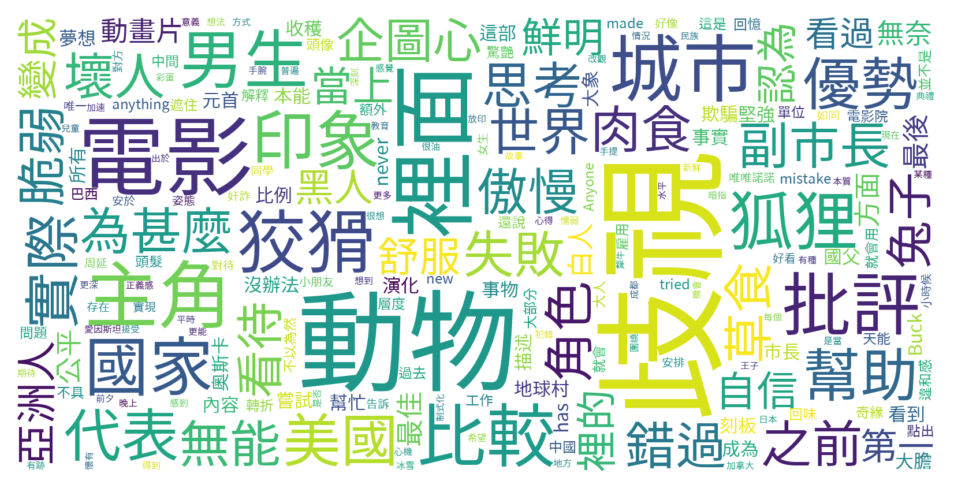

In [ ]:
font_path = 'TaipeiSansTCBeta-Regular.ttf' # 設定字型
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

關鍵字出現了「歧視」的關鍵字，對此進一步分析

(np.float64(-0.5), np.float64(1599.5), np.float64(799.5), np.float64(-0.5))

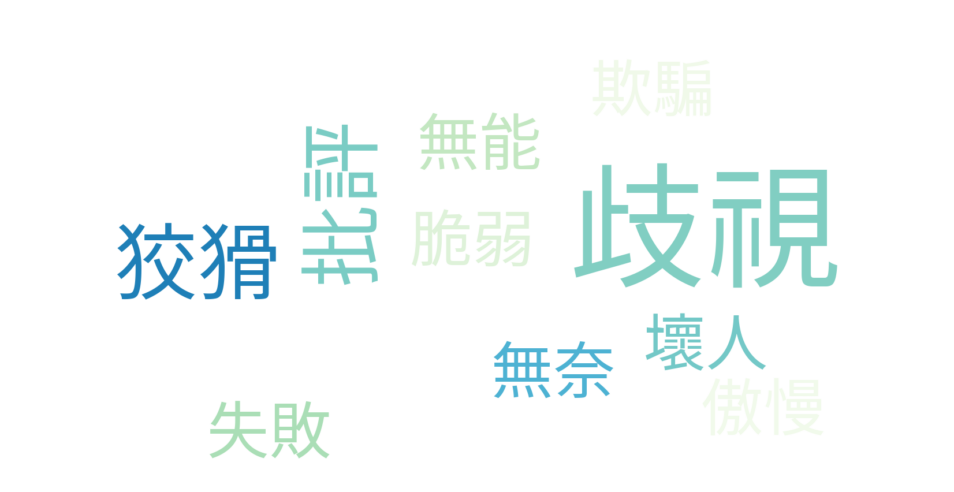

In [ ]:
date = "2016-01-15"
end_date = "2016-07-15"
mask = (ptt_liwc_df_revise["date"] >= start_date) & \
       (ptt_liwc_df_revise["date"] <= end_date) & \
       (ptt_liwc_df_revise["sentiment_class"] == "負向") & ( # 負面文章
    ptt_liwc_df_revise['content'].str.contains('歧視')) & ( # 內文包含歧視
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["date", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud,
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

利用「歧視」去查看原文內容

In [ ]:
date = "2016-01-15"
end_date = "2016-07-15"
mask = (sent_df["date"] >= start_date) & \
       (sent_df["date"] <= end_date) & \
       (sent_df["sentiment_class"] == "負向") & \
       (sent_df["content"].str.contains("歧視")) & \
       (sent_df["sentence"].str.contains("歧視"))

df_ = sent_df.loc[mask, ["date", "content", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df[['title', 'sentence', 'sentiment_class']]

title                     sentence sentiment_class
4927  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                自己認為自己沒辦法給主角幫忙              負向
4928  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                     所以帶主角去見大象              負向
4929  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                  最後其實都是他在幫助主角              負向
4930  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                         給主角線索              負向
4931  [好雷]《動物方城市》--好看如同《腦筋急轉彎》               還說希望有天能跟大象記憶一樣好              負向
4932  [好雷]《動物方城市》--好看如同《腦筋急轉彎》             看完這部電影對歧視有更深一層的體悟              負向
4933  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                        在看電影之前              負向
4934  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                  身旁的教育平時就告訴我們              負向
4935  [好雷]《動物方城市》--好看如同《腦筋急轉彎》           不能因為對方的種族職業各方面懷有歧視喔              負向
4936  [好雷]《動物方城市》--好看如同《腦筋急轉彎》               但過去總覺得這樣的想法過於虛假              負向
4937  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                         而不以為然              負向
4938  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                  認為歧視是出於我們的本能              負向
4939  [好雷]《動物方城市》--好看如同《腦筋急轉彎》              本能對於比較沒辦法幫助到我們的人              負向
4940  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                本來就會用比較傲慢的姿態對待              負向
4941  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                  所有的歧視並不會空穴來風              負向
4942  [好雷]《動物方城市》--好看如同《腦筋急轉彎》             歧視在本質上都是描述某種層度的事實              負向
4943  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                 像以前美國的白人會歧視黑人              負向
4944  [好雷]《動物方城市》--好看如同《腦筋急轉彎》            的確當時黑人的生活水平各方面不如白人              負向
4945  [好雷]《動物方城市》--好看如同《腦筋急轉彎》       之前奧斯卡典禮主持人安排亞裔兒童手提公事包上台              負向
4946  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                    被大家批評歧視亞洲人              負向
4947  [好雷]《動物方城市》--好看如同《腦筋急轉彎》       但亞洲人的確更高的比例在雇用童工做制式化的工作              負向
4948  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                    為甚麼有人點出事實後              負向
4949  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                        反而要被批評              負向
4950  [好雷]《動物方城市》--好看如同《腦筋急轉彎》   但看到這部電影裡面狐狸回憶他小時候的遭遇的事情後改觀了              負向
4951  [好雷]《動物方城市》--好看如同《腦筋急轉彎》     或許電影裡的世界狐狸的確有更高的比例是很狡猾的動物              負向
4953  [好雷]《動物方城市》--好看如同《腦筋急轉彎》             但如果存在這種刻板印象看待每隻狐狸              負向
4954  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                  這樣對個體來說是不公平的              負向
4955  [好雷]《動物方城市》--好看如同《腦筋急轉彎》              像主角狐狸一開始只是很想融入大家              負向
4956  [好雷]《動物方城市》--好看如同《腦筋急轉彎》              最後卻變成不得不跟大家的期待一樣              負向
4957  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                 無奈的成為一隻很狡猾的動物              負向
4958  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                     因為歧視行為的本身              負向
4959  [好雷]《動物方城市》--好看如同《腦筋急轉彎》            會加速讓社會成為歧視所描述的內容實現              負向
4960  [好雷]《動物方城市》--好看如同《腦筋急轉彎》              看完電影時一直跟同學思考一個問題              負向
4961  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                為甚麼在一個九成都是草食動物              負向
4962  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                   一成才是肉食動物的城市              負向
4963  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                      市長卻是肉食動物              負向
4964  [好雷]《動物方城市》--好看如同《腦筋急轉彎》                 草食動物反而是當魁儡副市長              負向

腦筋急轉彎此時討論度已大幅下降，負向情緒增加的原因是來自於網友對動物方程式的評論

我們想了解腦筋急轉彎第二集後段正向情緒增加原因

In [ ]:
# 轉換 date 欄位為 datetime 型別
ptt_liwc_df_revise["date"] = pd.to_datetime(ptt_liwc_df_revise["date"])

# 設定篩選條件
start_date = "2024-08-15"
end_date = "2024-11-15"

mask = (ptt_liwc_df_revise["date"] >= start_date) & \
       (ptt_liwc_df_revise["date"] <= end_date) & \
       (ptt_liwc_df_revise["sentiment_class"] == "正向")

# 過濾資料
ptt_df_wc = ptt_liwc_df_revise.loc[mask]

# 顯示結果
ptt_df_wc


link       date  \
56    https://www.ptt.cc/bbs/movie/M.1731402388.A.8D... 2024-11-12   
57    https://www.ptt.cc/bbs/movie/M.1731402388.A.8D... 2024-11-12   
58    https://www.ptt.cc/bbs/movie/M.1731402388.A.8D... 2024-11-12   
59    https://www.ptt.cc/bbs/movie/M.1731402388.A.8D... 2024-11-12   
60    https://www.ptt.cc/bbs/movie/M.1731402388.A.8D... 2024-11-12   
...                                                 ...        ...   
1257  https://www.ptt.cc/bbs/movie/M.1725262698.A.A6... 2024-09-02   
1258  https://www.ptt.cc/bbs/movie/M.1725262698.A.A6... 2024-09-02   
1259  https://www.ptt.cc/bbs/movie/M.1725262698.A.A6... 2024-09-02   
1260  https://www.ptt.cc/bbs/movie/M.1725262698.A.A6... 2024-09-02   
1261  https://www.ptt.cc/bbs/movie/M.1725262698.A.A6... 2024-09-02   

                 title                                            content  \
56         [普雷] 腦筋急轉彎2  雷文防雷資訊頁\n\n\n\n\n\n\n\n~~~~~~~~~~~~~~~~~~~ 雷文 ...   
57         [普雷] 腦筋急轉彎2  雷文防雷資訊頁\n\n\n\n\n\n\n\n~~~~~~~~~~~~~~~~~~~ 雷文 ...   
58         [普雷] 腦筋急轉彎2  雷文防雷資訊頁\n\n\n\n\n\n\n\n~~~~~~~~~~~~~~~~~~~ 雷文 ...   
59         [普雷] 腦筋急轉彎2  雷文防雷資訊頁\n\n\n\n\n\n\n\n~~~~~~~~~~~~~~~~~~~ 雷文 ...   
60         [普雷] 腦筋急轉彎2  雷文防雷資訊頁\n\n\n\n\n\n\n\n~~~~~~~~~~~~~~~~~~~ 雷文 ...   
...                ...                                                ...   
1257  [選片] 腦筋急轉彎2 驀然回首  現在剛好有空檔時間想挑一部來看\n目前對這兩部動畫片有興趣\n雖然都上檔一段時間了但都還沒時...   
1258  [選片] 腦筋急轉彎2 驀然回首  現在剛好有空檔時間想挑一部來看\n目前對這兩部動畫片有興趣\n雖然都上檔一段時間了但都還沒時...   
1259  [選片] 腦筋急轉彎2 驀然回首  現在剛好有空檔時間想挑一部來看\n目前對這兩部動畫片有興趣\n雖然都上檔一段時間了但都還沒時...   
1260  [選片] 腦筋急轉彎2 驀然回首  現在剛好有空檔時間想挑一部來看\n目前對這兩部動畫片有興趣\n雖然都上檔一段時間了但都還沒時...   
1261  [選片] 腦筋急轉彎2 驀然回首  現在剛好有空檔時間想挑一部來看\n目前對這兩部動畫片有興趣\n雖然都上檔一段時間了但都還沒時...   

     word sentiments sentiment_class  
56     資訊        NaN              正向  
57     好像        NaN              正向  
58     好像        NaN              正向  
59     比較        NaN              正向  
60     情緒     affect              正向  
...   ...        ...             ...  
1257   驚喜   positive              正向  
1258   亮點        NaN              正向  
1259   整體        NaN              正向  
1260   感想        NaN              正向  
1261   平平        NaN              正向  

[491 rows x 7 columns]

In [ ]:
date = "2024-08-15"
end_date = "2024-11-15"
mask = (ptt_liwc_df_revise["date"] >= start_date) & \
       (ptt_liwc_df_revise["date"] <= end_date) & \
       (ptt_liwc_df_revise["sentiment_class"] == "正向")

ptt_wd_wc = ptt_liwc_df_revise.loc[mask, ["date", "word"]]

word_count_count = pd.DataFrame(
    ptt_wd_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

word  size
114    情緒    14
190    焦慮    12
170    朋友     8
306    電影     7
247    萊莉     6
..    ...   ...
122   慶生會     1
121    感觸     1
119  感同身受     1
117   意識到     1
129    打算     1

[319 rows x 2 columns]

(np.float64(-0.5), np.float64(1599.5), np.float64(799.5), np.float64(-0.5))

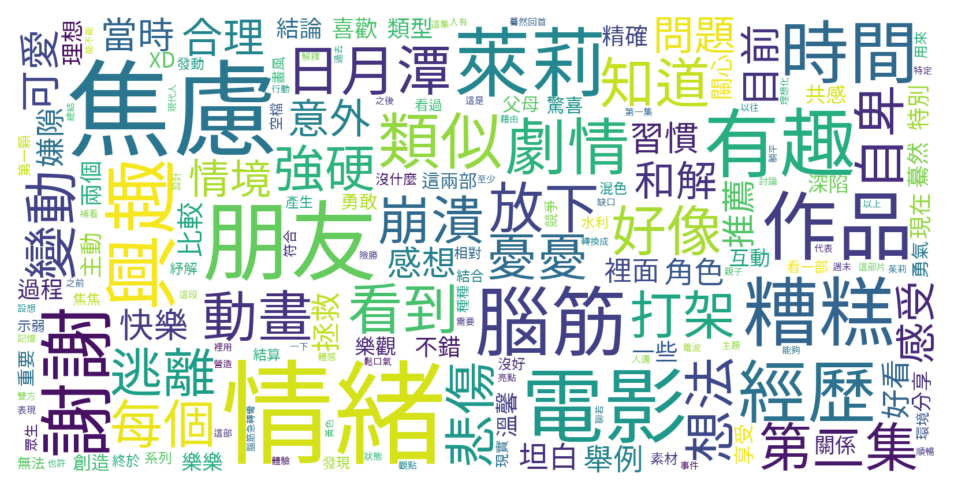

In [ ]:
font_path = 'TaipeiSansTCBeta-Regular.ttf' # 設定字型
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

關鍵字出現了「情緒」的關鍵字，對此進一步分析

(np.float64(-0.5), np.float64(1599.5), np.float64(799.5), np.float64(-0.5))

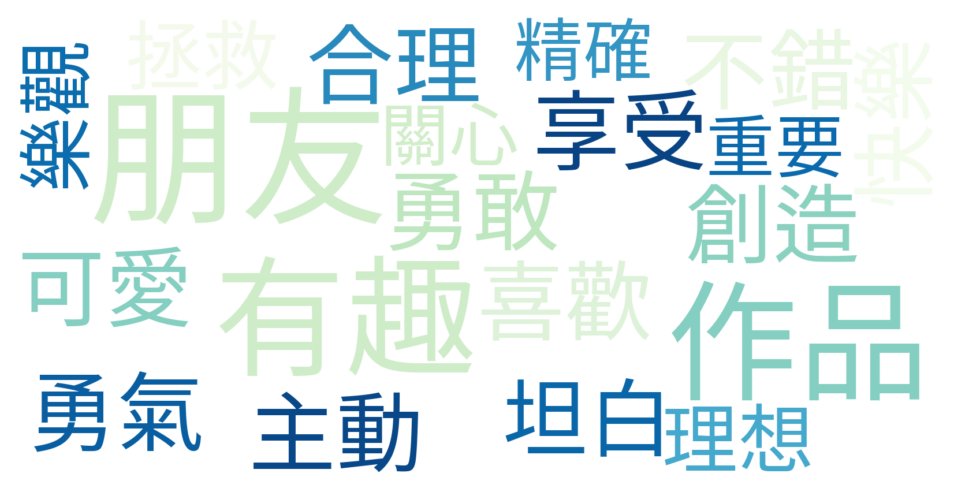

In [ ]:
date = "2024-08-15"
end_date = "2024-11-15"
mask = (ptt_liwc_df_revise["date"] >= start_date) & \
       (ptt_liwc_df_revise["date"] <= end_date) & \
       (ptt_liwc_df_revise["sentiment_class"] == "正向") & ( # 正面文章
    ptt_liwc_df_revise['content'].str.contains('情緒')) & ( # 內文包含情緒
    ptt_liwc_df_revise["sentiments"] == "positive") # 正面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["date", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud,
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

利用「朋友」去查看原文內容

In [ ]:
date = "2024-08-15"
end_date = "2024-11-15"
mask = (sent_df["date"] >= start_date) & \
       (sent_df["date"] <= end_date) & \
       (sent_df["sentiment_class"] == "正向") & \
       (sent_df["content"].str.contains("情緒")) & \
       (sent_df["sentence"].str.contains("朋友"))

df_ = sent_df.loc[mask, ["date", "content", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df[['title', 'sentence', 'sentiment_class']]

title             sentence sentiment_class
94   Re: [討論] 覺得腦筋急轉彎好看的原因                   但是              正向
95   Re: [討論] 覺得腦筋急轉彎好看的原因   只是類似就代表過程感受不可能完全一樣              正向
96   Re: [討論] 覺得腦筋急轉彎好看的原因            更何況結論這種東西              正向
97   Re: [討論] 覺得腦筋急轉彎好看的原因   更會隨著年紀經歷其他重要事件而有變動              正向
98   Re: [討論] 覺得腦筋急轉彎好看的原因     我們當然知道人有嫌隙要敞開心胸講              正向
99   Re: [討論] 覺得腦筋急轉彎好看的原因      就像第二集萊莉跟那兩個朋友一樣              正向
100  Re: [討論] 覺得腦筋急轉彎好看的原因           然而要雙方都這麼勇敢              正向
101  Re: [討論] 覺得腦筋急轉彎好看的原因                 真的很難              正向
102  Re: [討論] 覺得腦筋急轉彎好看的原因        而正因為理想跟現實差得很遠              正向
103  Re: [討論] 覺得腦筋急轉彎好看的原因          才會有電影填補這個缺口              正向
104  Re: [討論] 覺得腦筋急轉彎好看的原因       每個人都經歷過更換環境的焦慮              正向
111  Re: [討論] 覺得腦筋急轉彎好看的原因                 尤其她爸              正向
112  Re: [討論] 覺得腦筋急轉彎好看的原因            既不是強硬要她習慣              正向
113  Re: [討論] 覺得腦筋急轉彎好看的原因          也不是示弱搬回明尼蘇達              正向
114  Re: [討論] 覺得腦筋急轉彎好看的原因      而是坦白告訴她我也有一樣的感受              正向
115  Re: [討論] 覺得腦筋急轉彎好看的原因        讓她覺得自己有伴能抒發情緒              正向
116  Re: [討論] 覺得腦筋急轉彎好看的原因           第二集的朋友關係也是              正向
117  Re: [討論] 覺得腦筋急轉彎好看的原因      在夏令營分組下充滿競爭的關係裡              正向
118  Re: [討論] 覺得腦筋急轉彎好看的原因        萊莉的朋友放下嫌隙主動關心              正向
119  Re: [討論] 覺得腦筋急轉彎好看的原因    她自己也意識到這段日子的某些不合適              正向
120  Re: [討論] 覺得腦筋急轉彎好看的原因            才能促成彼此的和解              正向
121  Re: [討論] 覺得腦筋急轉彎好看的原因       以上這些過程或許真的太理想化              正向
122  Re: [討論] 覺得腦筋急轉彎好看的原因                  只不過              正向
123  Re: [討論] 覺得腦筋急轉彎好看的原因      我們也會從中看到以往類似經歷裡              正向
124  Re: [討論] 覺得腦筋急轉彎好看的原因        當時應該能走出來的另一條路              正向
125  Re: [討論] 覺得腦筋急轉彎好看的原因       一個當時好像能做得更好的自己              正向
126  Re: [討論] 覺得腦筋急轉彎好看的原因      不管我們是萊莉朋友還是父母身分              正向
127  Re: [討論] 覺得腦筋急轉彎好看的原因          經歷或結論類似是一回事              正向
128  Re: [討論] 覺得腦筋急轉彎好看的原因                  重點是              正向
129  Re: [討論] 覺得腦筋急轉彎好看的原因     你會在裡面看到曾經且能更好的自己              正向
130  Re: [討論] 覺得腦筋急轉彎好看的原因  這是這系列兩部作品我覺得劇情不錯的地方              正向
131  Re: [討論] 覺得腦筋急轉彎好看的原因             即使過去無法改變              正向

## 4.情緒分析二

### 4.1 套件安裝

In [ ]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import re
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime

In [ ]:
# 套用字體以顯示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # MacOS 內建中文字體
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體

In [ ]:
data_utils.download_data_gdown("./")  # 下載ckip model

In [ ]:
#將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/Users/wengwulin/Desktop/社群媒體分析/SMAenv/lib/python3.11/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/Users/wengwulin/Desktop/社群媒體分析/SMAenv/lib/python3.11/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/Users/wengwulin/Desktop/社群媒體分析/SMAenv/lib/python3.11/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensor

### 4.2 CKIP處理

In [ ]:
df = pd.read_csv('./raw_data/InsideOut.csv')
df.head()

title  \
0  [情報] 來自腦筋急轉彎的世界 夢境製片廠 預告   
1               [普雷] 腦筋急轉彎2   
2         [普雷] 腦筋急轉彎2 想再次二刷   
3  [普雷] 腦筋急轉彎2 Inside Out 2   
4     Re: [討論] 覺得腦筋急轉彎好看的原因   

                                                link        date  \
0  https://www.ptt.cc/bbs/movie/M.1733494251.A.9A...  2024-12-06   
1  https://www.ptt.cc/bbs/movie/M.1731402388.A.8D...  2024-11-12   
2  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...  2024-11-06   
3  https://www.ptt.cc/bbs/movie/M.1730512420.A.83...  2024-11-02   
4  https://www.ptt.cc/bbs/movie/M.1727531647.A.21...  2024-09-28   

                                          artContent  system_id  
0  https://www.youtube.com/watch?v=OVD1x6gJzaY\n之...          1  
1  雷文防雷資訊頁\n\n\n\n\n\n\n\n~~~~~~~~~~~~~~~~~~~ 雷文 ...          2  
2  雷文防雷資訊頁\n\n\n\n\n\n\n\n~*-*~*-*~*-*~*-*~*-*~*-...          3  
3  ~~~~~~~~~~~~~~~~~~~ 雷文 主文分隔線 ~~~~~~~~~~~~~~~~~...          4  
4  原PO你好，你在文章裡用的舉例跟形容讓我很有想法，\n這邊針對一些段落回覆跟討論。\n\n\...          5

In [ ]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")


    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)

    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)

            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space

            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            clean_paragraph = re.sub(r'\\', '', clean_paragraph)

        except:
            return "error"

        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)

    return result

In [ ]:
# 自定義辭典
with open('dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'樂樂': 500.0, '怒怒': 500.0, '憂憂': 500.0, '阿慕': 500.0, '阿廢': 500.0, '阿焦': 500.0}), (5, {'腦筋急轉彎': 500.0})]


In [ ]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos])
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]])
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []

    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level
    # print(f"\ndocument {index}")

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent'])
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)

    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat,
                    columns=['system_id','word','pos'])

    entity_table = pd.DataFrame(data=entity_flat,
                        columns=['system_id','word','ner'])

    sentence_table = pd.DataFrame(data=sentence_list,
                    columns=['system_id','sentence'])

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [ ]:
# tmp 和 flat_list 的差別
tmp = Sentence_Segmentation(df['artContent'][0])
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['///'], ['之前看腦筋的時候，就很喜歡夢境製片廠的橋段'], ['那時候就有和樂樂憂憂起去過夢境製片廠'], ['不知道大家是否還記得'], ['///']]
['///', '之前看腦筋的時候，就很喜歡夢境製片廠的橋段', '那時候就有和樂樂憂憂起去過夢境製片廠', '不知道大家是否還記得', '///']


In [ ]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 95.87891817092896


In [ ]:
pos_table.head() # word pos 列表

system_id word pos
0          1  ///  FW
1          1   之前  Nd
2          1    看  VC
3          1   腦筋  Na
4          1    的  DE

In [ ]:
entity_table.head() # word entity 列表

system_id   word     ner
0          1  夢境製片廠     ORG
1          1  夢境製片廠     ORG
2          2     雷文  PERSON
3          2     茱莉  PERSON
4          2     阿廢  PERSON

In [ ]:
sentence_table.head()

system_id               sentence
0          1                    ///
1          1  之前看腦筋的時候，就很喜歡夢境製片廠的橋段
2          1     那時候就有和樂樂憂憂起去過夢境製片廠
3          1             不知道大家是否還記得
4          1                    ///

In [ ]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1628篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1620篇有抓到ner

total posts numbers: 200
posts have NER: 187


In [ ]:
# 將文章存成csv
pos_table.to_csv('raw_data/pos_table_InsideOut.csv', index = False)
entity_table.to_csv('raw_data/entity_table_InsideOut.csv', index = False)
sentence_table.to_csv('raw_data/sentence_table_InsideOut.csv', index = False)

### 4.3 探索分析 - NER

In [ ]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/pos_table_InsideOut.csv")
entity_table = pd.read_csv("raw_data/entity_table_InsideOut.csv")
sentence_table = pd.read_csv("raw_data/sentence_table_InsideOut.csv")

#### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [ ]:
entity_table['ner'].unique()

array(['ORG', 'PERSON', 'CARDINAL', 'ORDINAL', 'GPE', 'LOC', 'DATE',
       'TIME', 'NORP', 'LANGUAGE', 'MONEY', 'PERCENT', 'EVENT', 'FAC',
       'WORK_OF_ART', 'PRODUCT', 'QUANTITY'], dtype=object)

In [ ]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

ner  count
12    PERSON    995
1       DATE    291
0   CARDINAL    229
7      MONEY    173
10       ORG    159
9    ORDINAL    159
4        GPE    143
6        LOC     97
5   LANGUAGE     56
15      TIME     35

Text(0.5, 0, 'Frequency')

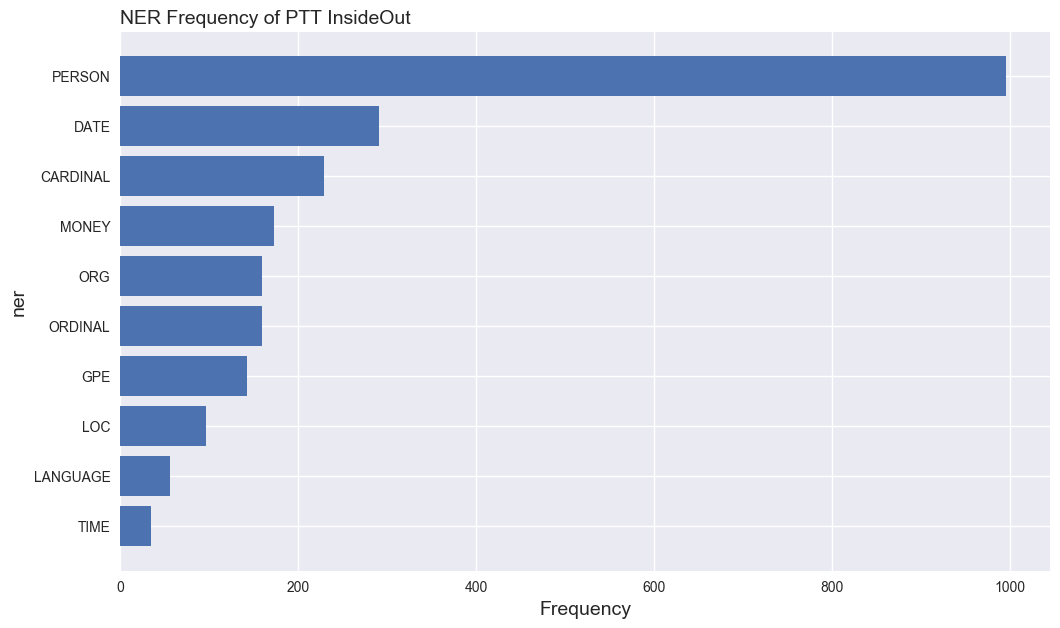

In [ ]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT InsideOut',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
# fig.show()

可以看到人的字頻比率十分的高

#### 涉及到的民族、宗教、政治團體(NORP)

Text(0.5, 0, 'Word Frequency')

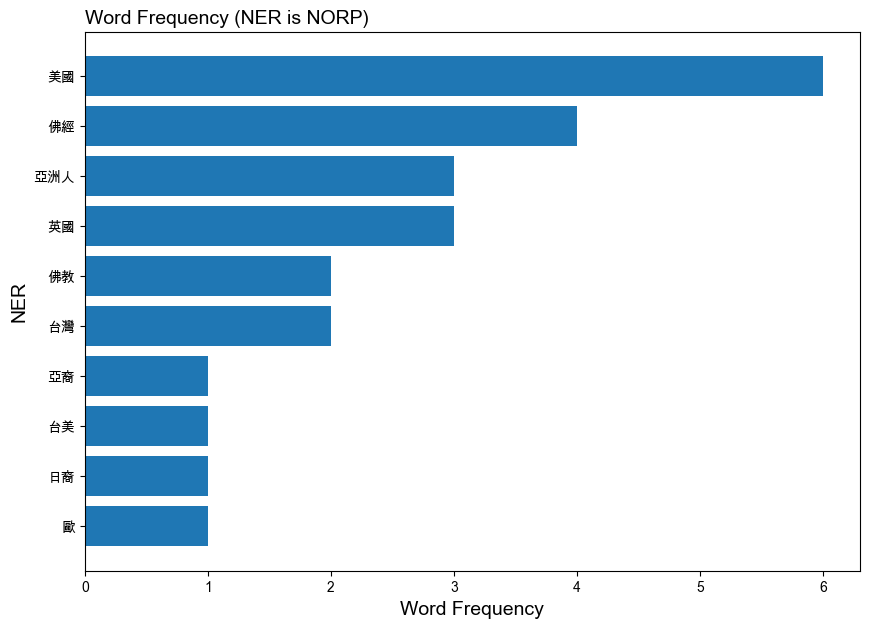

In [ ]:
# 篩選ner為NORP的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

可以觀察到，涉及到的民族、宗教、政治團體中，美國占絕大多數

#### 與主角相關的文章

In [ ]:
keyword_list = ['萊莉']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list), na=False, regex=True)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(3)

萊莉：63篇相關貼文


title  \
2          [普雷] 腦筋急轉彎2 想再次二刷   
4      Re: [討論] 覺得腦筋急轉彎好看的原因   
8  [普雷] 《腦筋急轉彎2》-從直銷進化成實用主義    

                                                link        date  \
2  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...  2024-11-06   
4  https://www.ptt.cc/bbs/movie/M.1727531647.A.21...  2024-09-28   
8  https://www.ptt.cc/bbs/movie/M.1725735701.A.45...  2024-09-08   

                                          artContent  system_id  
2  雷文防雷資訊頁\n\n\n\n\n\n\n\n~*-*~*-*~*-*~*-*~*-*~*-...          3  
4  原PO你好，你在文章裡用的舉例跟形容讓我很有想法，\n這邊針對一些段落回覆跟討論。\n\n\...          5  
8  雷文防雷資訊頁\n\n\n\n~*-*~*-*~*-*~*-*~*-*~*-*~*-*~*-...          9

#### 涉及到的組織(ORG)

Text(0.5, 0, 'Word Frequency')

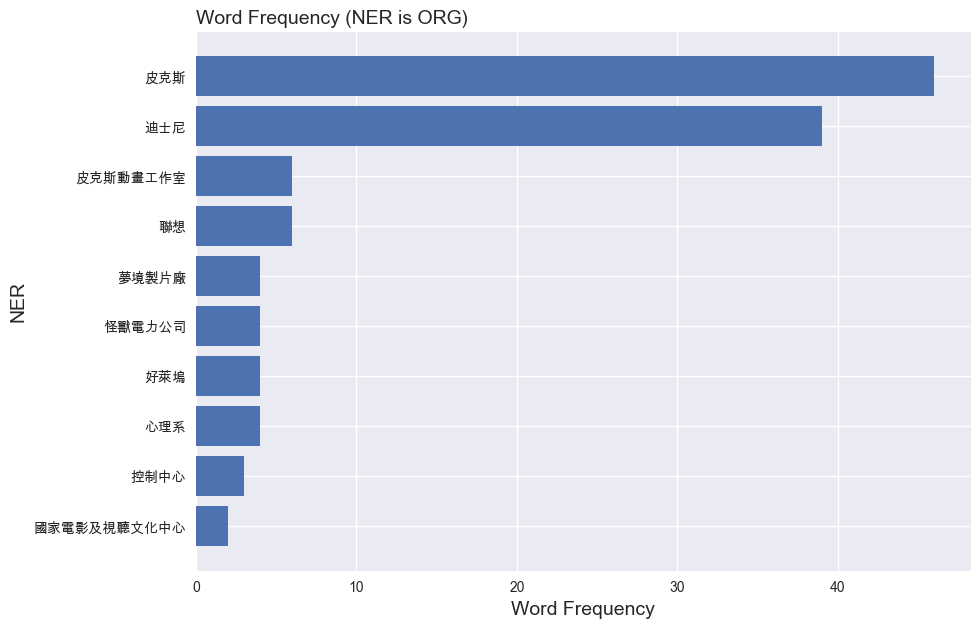

In [ ]:
# 篩選ner為ORG的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

可以看到皮克斯與迪士尼出現數量最多，因為這部動畫確實是由他們出品的

#### 涉及到的人名(PERSON)

Text(0.5, 0, 'Word Frequency')

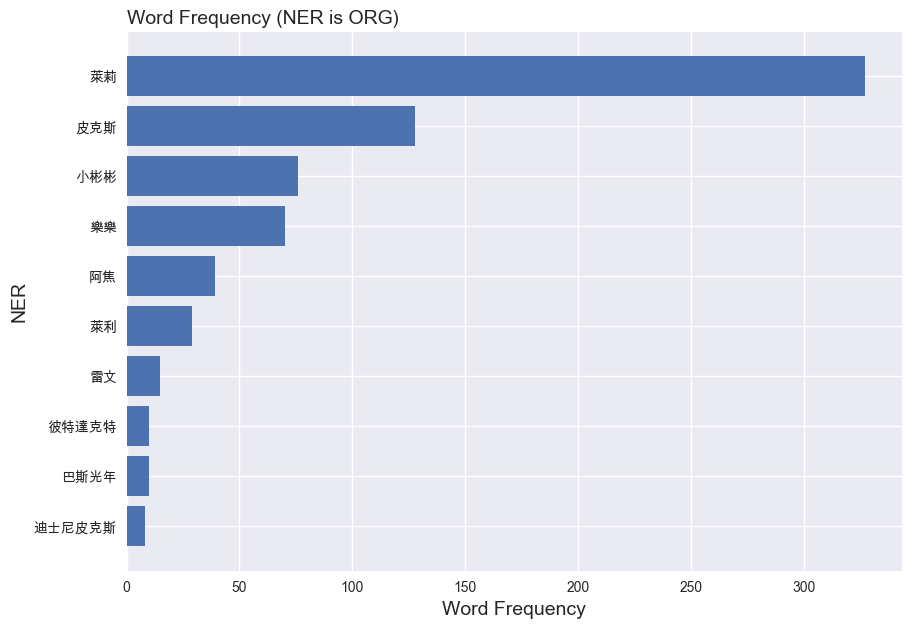

In [ ]:
# 篩選ner為ORG的資料
l_noun = ["PERSON"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

可以看到主角萊莉的數量出現最多，畢竟他是主角，故事也都是圍繞著他發展

### 4.4 探索分析 - POS
POS 種類分析 查看辨識出哪幾種POS

In [ ]:
pos_table['pos'].unique()

array(['FW', 'Nd', 'VC', 'Na', 'DE', 'COMMACATEGORY', 'D', 'Dfa', 'VK',
       'Nc', 'Nep', 'V_2', 'P', 'VH', 'VCL', 'Di', 'Nh', 'VE', 'Neu',
       'Nf', 'Ncd', 'SHI', 'T', 'VL', 'Dk', 'Nb', 'VA', 'Cbb', 'Ng', 'VJ',
       'Da', 'Caa', 'VHC', 'I', 'VD', 'Dfb', 'Neqa', 'Cba', 'Nes', 'A',
       'VB', 'VG', 'VF', 'Nv', 'Cab', 'VAC', 'VI', 'DM', 'COLONCATEGORY',
       'Neqb', 'PERIODCATEGORY', 'PARENTHESISCATEGORY'], dtype=object)

In [ ]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

pos  count
15   Na  13406
5     D   9103
41   VH   6485
6    DE   5499
35   VC   4133
27   Nh   3264
29    P   2800
25   Nf   2365
4   Cbb   2003
30  SHI   1941
38   VE   1930
45   VK   1603

/var/folders/tz/hplj27qd26n9qxr1cd83m32c0000gn/T/ipykernel_51034/293363437.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


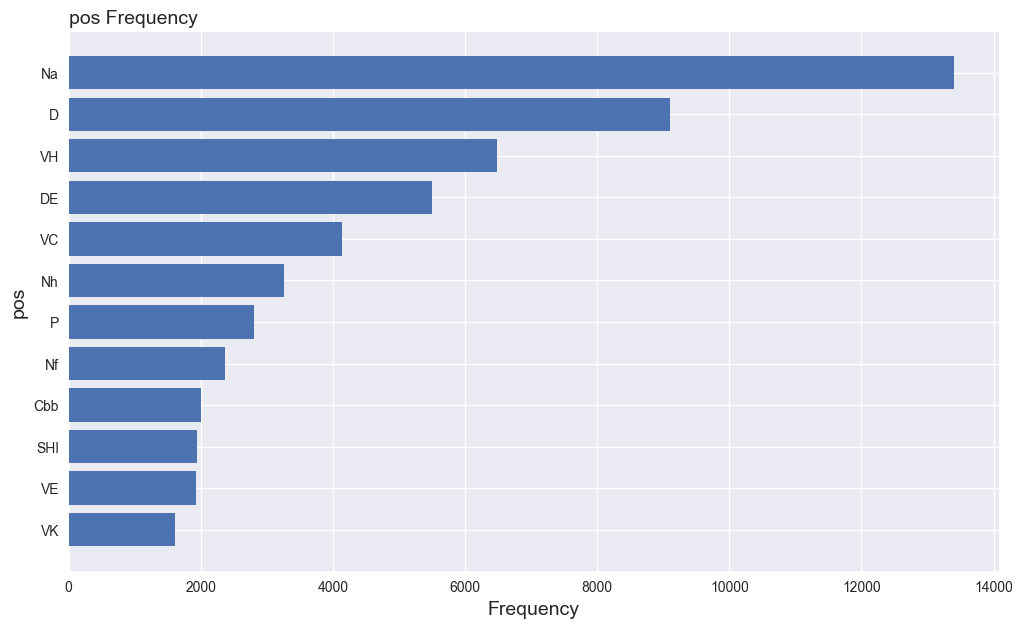

In [ ]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('pos Frequency',loc ='left', size = 14)
ax.set_ylabel('pos', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### 涉及到的名詞

In [ ]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

word  count
209     萊莉    365
166    皮克斯    186
75     小彬彬     81
263     阿焦     55
238    迪士尼     48
207     萊利     30
281     雷文     15
190  腦筋急轉彎     12
101  彼特達克特     10
88      巴斯      9

/var/folders/tz/hplj27qd26n9qxr1cd83m32c0000gn/T/ipykernel_51034/488784228.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


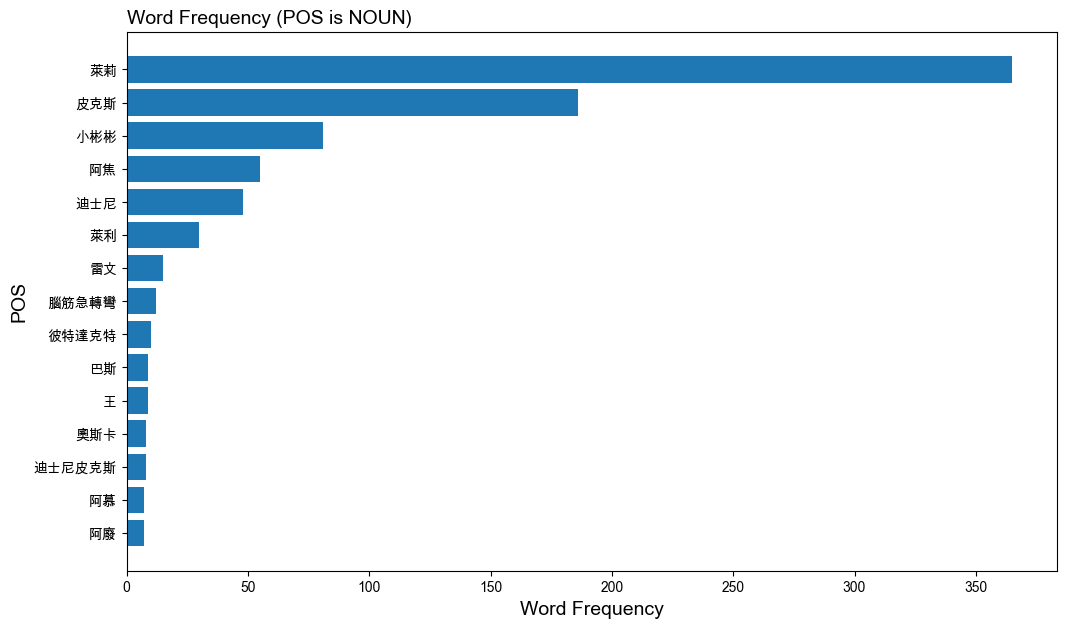

In [ ]:
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

#### 涉及到的動詞(VERB)

In [ ]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

word  count
629   看完     80
926   面對     67
389   控制     55
733   表現     45
772   設定     45
14    主導     42
383   接受     38
735   表達     34
635   看過     32
611   發展     30
399   推薦     30
816   超越     27
386   接納     25
231   幫助     24
922   離開     22

/var/folders/tz/hplj27qd26n9qxr1cd83m32c0000gn/T/ipykernel_51034/29217454.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


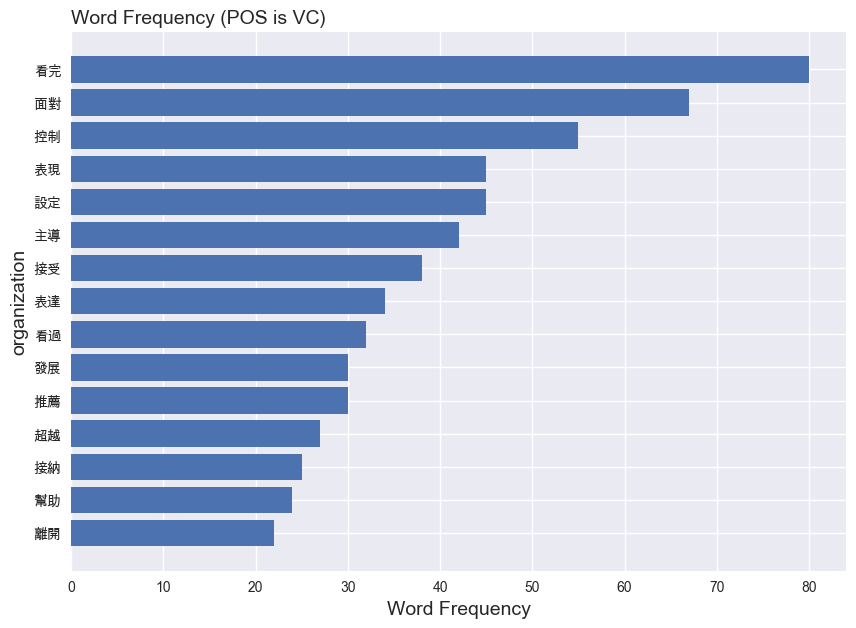

In [ ]:
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is VC)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 4.5 利用SnowNLP進行情緒分析
- SnowNLP 針對中文設計，可以提取句子的情緒分類
- 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
- 情緒值在 0~1之間，代表負面到正面

In [ ]:
from snownlp import SnowNLP
s = SnowNLP('這部電影很讚')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.786074481210413

In [ ]:
sentence_table = pd.read_csv("raw_data/sentence_table_insideOut.csv") #匯資料

sentiment_date = pd.merge(sentence_table,shu_selected[['system_id','date','link']],on='system_id',how='left').dropna()
sentiment_date.head(3)

system_id                                           sentence        date  \
38          3                                            雷文防雷資訊頁  2024-11-06   
39          3                                      ~~~~~~~~~~~~~  2024-11-06   
40          3  ~~~~~~~~~~~~~~~~~~~雷文主文分隔線~~~~~~~~~~~~~~~~~~~~...  2024-11-06   

                                                 link  
38  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...  
39  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...  
40  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...

In [ ]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

system_id                                           sentence        date  \
38          3                                            雷文防雷資訊頁  2024-11-06   
39          3                                      ~~~~~~~~~~~~~  2024-11-06   
40          3  ~~~~~~~~~~~~~~~~~~~雷文主文分隔線~~~~~~~~~~~~~~~~~~~~...  2024-11-06   

                                                 link  sentimentValue  
38  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...        0.996219  
39  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...        0.111111  
40  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...        0.819458

In [ ]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    3.474000e+03
mean     5.145763e-01
std      3.514057e-01
min      1.372389e-07
25%      1.625423e-01
50%      5.262328e-01
75%      8.650518e-01
max      1.000000e+00
Name: sentimentValue, dtype: float64

<Axes: >

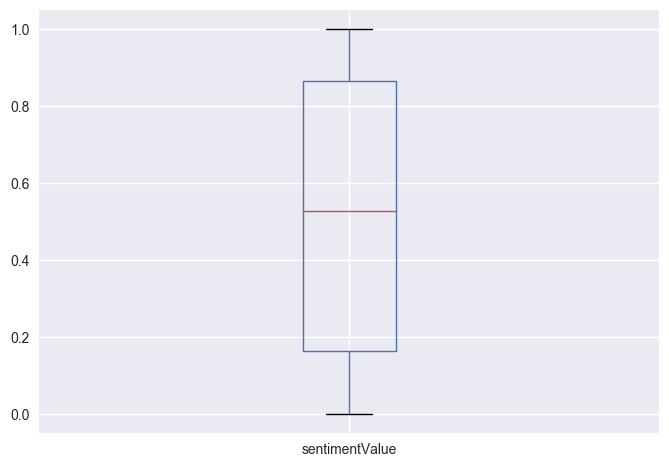

In [ ]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

由箱型圖觀察，對腦筋急轉彎的評價算是中立偏上

#### 將每個月的情緒分數取平均，並轉換時間格式為年月

In [ ]:
sent_date = sentiment_date.copy()
sent_date['date'] =  pd.to_datetime(sentiment_date['date']).dt.to_period('M')

sentiment_count = sent_date.groupby(['date'])['sentimentValue'].mean().reset_index()
sentiment_count

date  sentimentValue
0   2015-08        0.538598
1   2015-09        0.509368
2   2015-11        0.565899
3   2016-12        0.440206
4   2017-11        0.562523
5   2018-03        0.477627
6   2021-07        0.622530
7   2021-11        0.615959
8   2023-11        0.582757
9   2024-03        0.655446
10  2024-05        0.561704
11  2024-06        0.489184
12  2024-07        0.492127
13  2024-08        0.537924
14  2024-09        0.444900
15  2024-11        0.505724

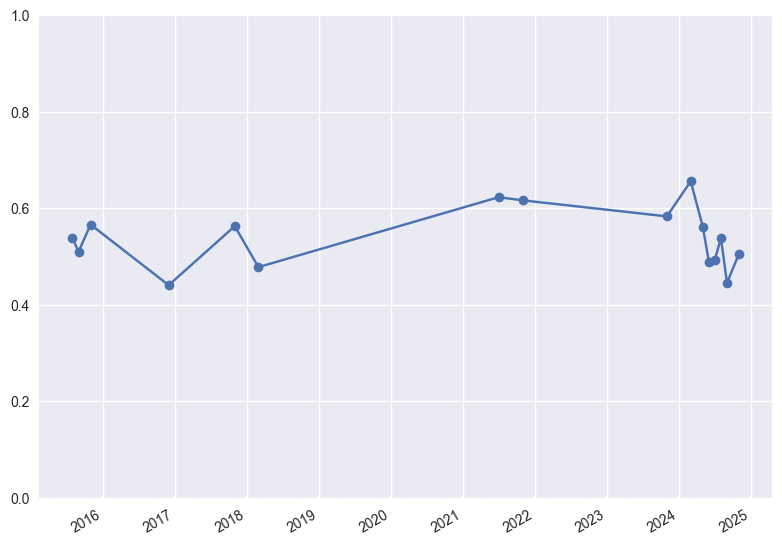

In [ ]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['date']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn-v0_8')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

可以看到腦筋急轉彎在2015剛上映第一部時，獲得較好的回響，然而隨著時間的推移，其受到關注也逐漸降低，甚至在2019至2021年間無任何評論，一直到2024年6月10日上映第二部前，對其的正面期待提升到了高峰，最後隨著上映後評價逐漸降低

#### 正面

In [ ]:
# 篩時間
filter_sentiment = sent_date[sent_date['date']=='2024-11']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

system_id                                           sentence     date  \
38          3                                            雷文防雷資訊頁  2024-11   
40          3  ~~~~~~~~~~~~~~~~~~~雷文主文分隔線~~~~~~~~~~~~~~~~~~~~...  2024-11   
41          3                          我依然記得看完第集的感動，所以也是抱著期待心情觀看  2024-11   
42          3                                 這集出現了新的情緒_阿焦阿慕阿廢阿羞  2024-11   
45          3                                      青春期不就是也很容易叛逆嗎  2024-11   

                                                 link  sentimentValue  
38  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...        0.996219  
40  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...        0.819458  
41  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...        0.991728  
42  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...        0.940545  
45  https://www.ptt.cc/bbs/movie/M.1730877121.A.8B...        0.996774

#### 負面

In [ ]:
#負面
filter_sentiment_n= sent_date[sent_date['date']=='2024-03']
filter_sentiment_n= filter_sentiment_n.loc[filter_sentiment_n['sentimentValue'] < 0.2]

filter_sentiment_n

system_id                                sentence     date  \
2533         82                                      //  2024-03   
2544         82  製作團隊細膩呈現這個時期所會經歷的所有尷尬時刻，操不完的心的焦焦別人的碗裡比  2024-03   
2548         82                                 是菩薩成佛之道  2024-03   
2550         82                                   是佛是菩薩  2024-03   

                                                   link  sentimentValue  
2533  https://www.ptt.cc/bbs/movie/M.1709997514.A.82...        0.200000  
2544  https://www.ptt.cc/bbs/movie/M.1709997514.A.82...        0.000337  
2548  https://www.ptt.cc/bbs/movie/M.1709997514.A.82...        0.167460  
2550  https://www.ptt.cc/bbs/movie/M.1709997514.A.82...        0.168492

In [ ]:
# 正面
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]

# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

pos_words.head(30)

system_id  sentimentValue                               word
0           3        0.996219                                 雷文
1           3        0.996219                                 防雷
2           3        0.996219                                資訊頁
3           3        0.996219                      ~~~~~~~~~~~~~
4           3        0.996219                ~~~~~~~~~~~~~~~~~~~
5           3        0.996219                               雷文主文
6           3        0.996219                                分隔線
7           3        0.996219  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
9           3        0.996219                                 依然
10          3        0.996219                                 記得
11          3        0.996219                                 看完
15          3        0.996219                                 感動
17          3        0.996219                                 所以
22          3        0.996219                                 期待
23          3        0.996219                                 心情
24          3        0.996219                                 觀看
27          3        0.996219                                 出現
31          3        0.996219                                 情緒
33          3        0.996219                                 阿焦
34          3        0.996219                                 阿慕
35          3        0.996219                                 阿廢
36          3        0.996219                                 阿羞
38          3        0.996219                                 覺得
41          3        0.996219                                 怎麼
42          3        0.996219                                 情緒
43          3        0.996219                                 有點
44          3        0.996219                                 分配
45          3        0.996219                                 不均
47          3        0.996219                                 雖說
48          3        0.996219                                青春期

In [ ]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', 

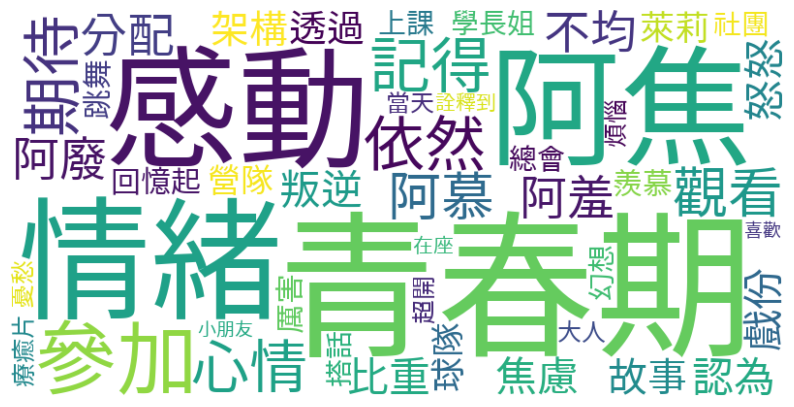

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('昨天','今天','最後'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'raw_data/TaipeiSansTCBeta-Regular.ttf' # 設定字型

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800,
                height = 400,
                max_words=100,
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (10,6))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

可以從上圖文字雲看到所有正面文章出現的詞彙

## 5.結論
- 分析結果顯示，《腦筋急轉彎》上映期間在PTT引起大量關注，討論熱度明顯上升，表明了該電影吸引了觀眾目光，並且成功引起觀眾共鳴。

- 腦筋急轉彎第一部回響很好，但隨著時間的推移，受到關注逐漸降低。第二部與第一部相比，負向情緒較高，但負面情緒多來自於針對電影設定的討論，而非來自於對電影的不滿。